<a href="https://colab.research.google.com/github/MNLepage08/YCNG-233/blob/main/Time_Series_Course_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
import time
import itertools
import os

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdate

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)

from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras import layers
from tensorflow.keras import initializers, regularizers
from keras import backend as K
from keras.losses import MeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import random

In [2]:
tf.keras.utils.set_random_seed(66)
tf.random.set_seed(66)

# **Resume**

### **Task 1:** Check what will be the best parameter N we should use for the one-hour-ahead electric load forecasting.

*   Choosing the optimim windows size can depend on a number of factors, including data characteristics and network topology.

*   With the order of first differences, the series are stationary and we can notice a 24 hours seasonality. PACF also helps to understanding the direct relastionship between an observation and it's specific lagged values. We can remark after 26 lags, the relationship is low.

*   Secondly, I experimented and ecaluated a first iteration of the models. The network topology is the same for both models. The only difference is in the hidden layers, I use dense or bidirectional LSTM. For certain sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backards and concatenate both interpretations.

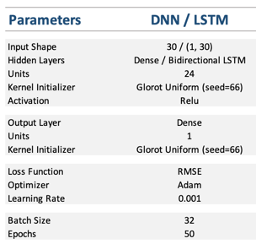

*    The table shows my results. We can see the best RMSE is for lags of 30, which allows better generalization.

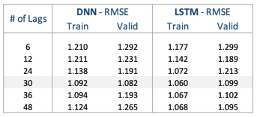

### **Task 2 - 3:** What is the best model architecture for the feedforward neural networks / LSTM you get? You should explain how the final architecture is determined.

*    The table below represent all the values I tried for optimizing my hyperparameter.

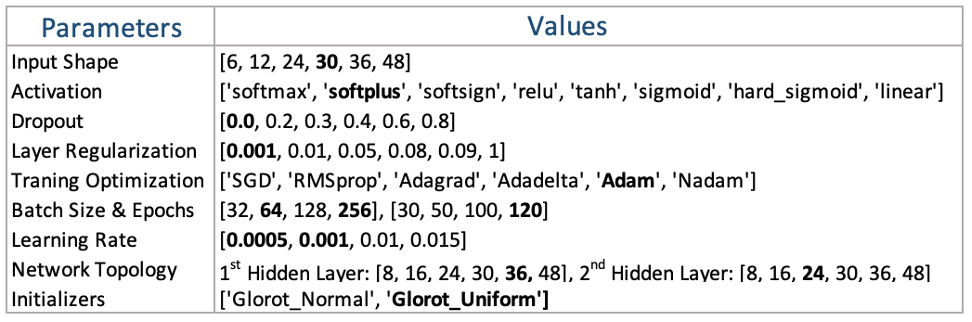

*    You can see all my iterations for hyperprameter optimization.

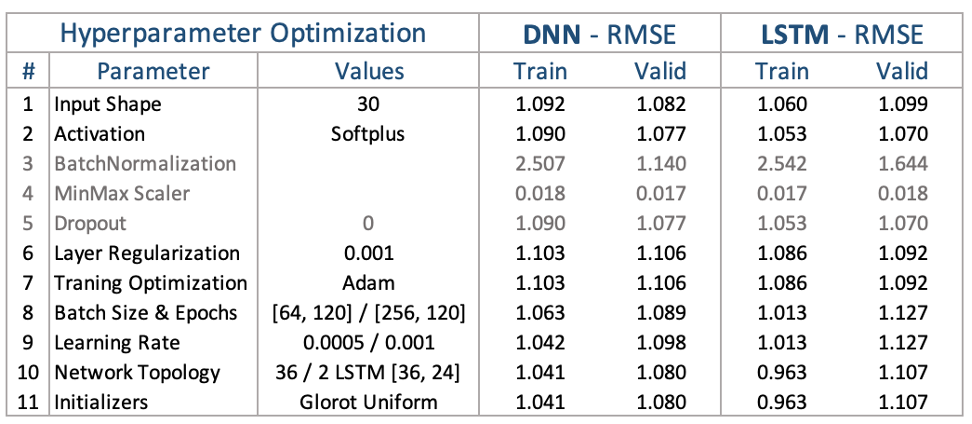

*   I have tried different activation functions, and the best is softplus.

*   Batch Normalization protect the vanishing and the exponent gradient. It applies a transformation thet maintains the mean output close to 0 and the standard deviation close to 1. When I experimented, my validation loss was higher of my training loss, which indicates that the validation dataset may be easier for the model to predict and is not representative. That's why I don't use this parameter.

*   Min Max Scaler is a preprocessing step (not a hyperparameter) to preserve data close to each other on scale of 0 to 1. This can help the model converge more faster and stable during training. In my loss graph, I don't detect this effect and for this reason I don't use this standardization. Note: In production is nightmare...

*   I use regularization to apply penalties on layer parameters during optimization. With ridge regression, I reduce the model complexity and avoid overfitting to improve model generalization performance by striking a balance between fiting the training data and maintaining model simplicity. My loss don't increase much, but my model generalizes better.

*   The best raining optimization is Adam, the same as in my first iteration.

*   The batch size defines the gradient and weights updated frequency. The epoch is the entire training data exposed to the network. The learning rate determines the rate at which a model's parameter are updated during the training process. Whitch these parameter, I reduce the variance.

*   I also tried different network topologies to add neurons for my optimal result. For my LSTM, I used a second hiddend layer with a return sequences in the first to return the entire sequence output.

*   Finally, I tried different initializers to set the initial random wieghts of the layers but my result didn't change.

You can see my final architecture in the table below.

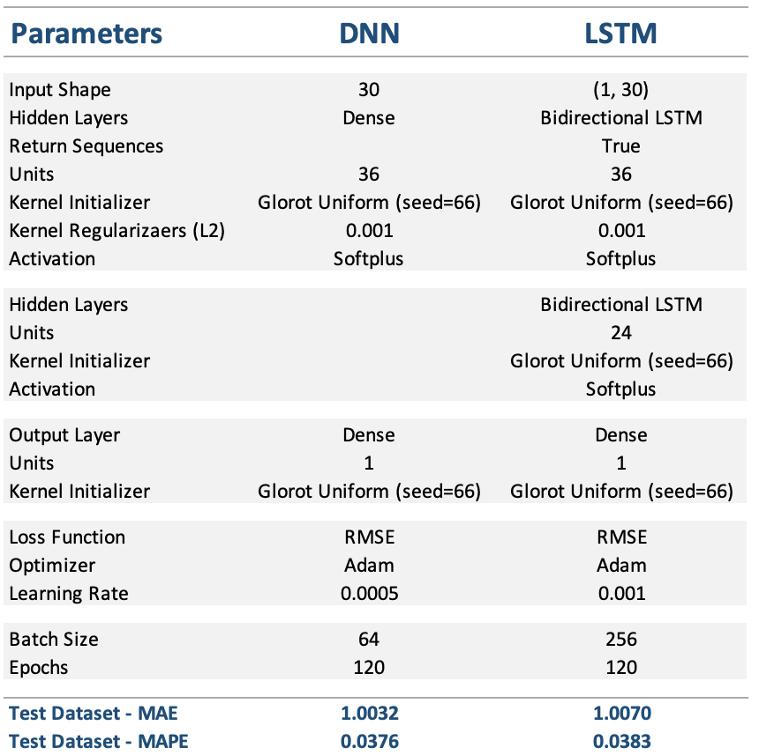

### **Result for DNN & LSTM:**

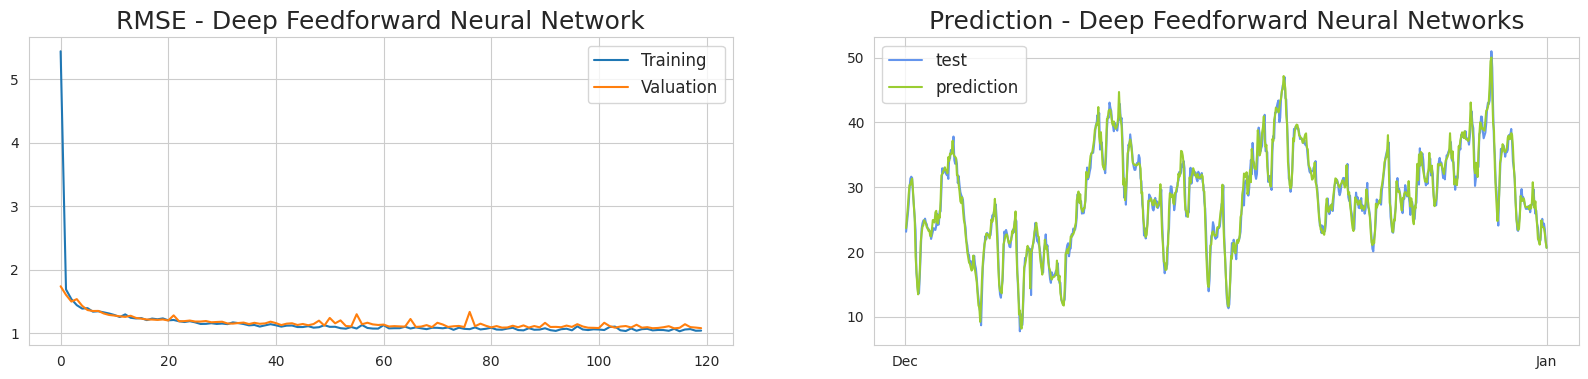

In [43]:
fig,ax=plt.subplots(1,2,figsize=(20,4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Valuation')
plt.title('RMSE - Deep Feedforward Neural Network', fontsize=18)
plt.grid(True)
plt.legend(fontsize=12)

plt.subplot(122)
plt.title('Prediction - Deep Feedforward Neural Networks', fontsize=18)
plt.plot(df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

plt.show()

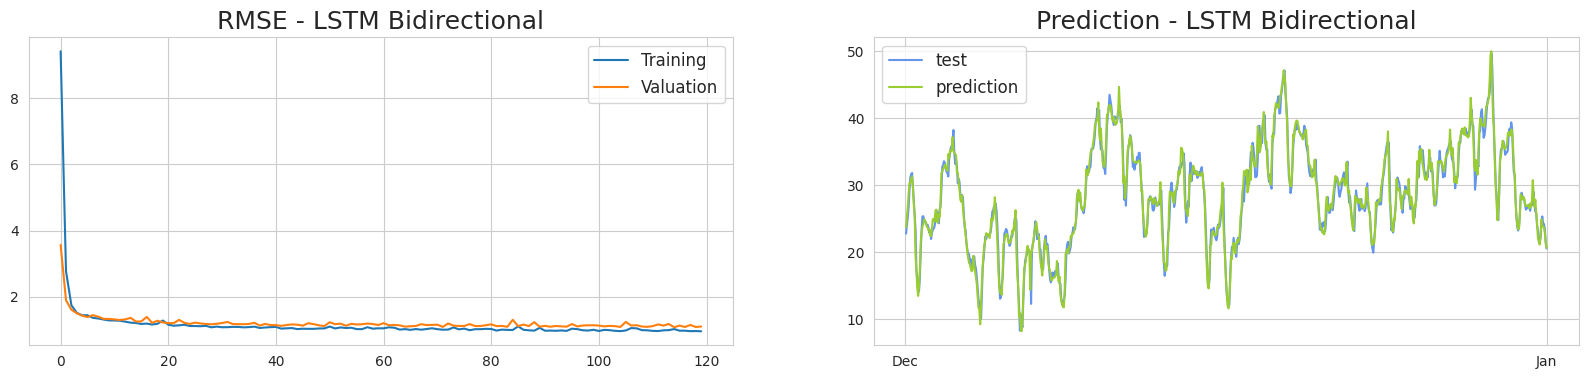

In [40]:
fig,ax=plt.subplots(1,2,figsize=(20,4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Valuation')
plt.title('RMSE - LSTM Bidirectional', fontsize=18)
plt.grid(True)
plt.legend(fontsize=12)

plt.subplot(122)
plt.title('Prediction - LSTM Bidirectional', fontsize=18)
plt.plot(df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

plt.show()

The RMSE graph shows that the model fit and generalizes well. The training and validation loss decrease to a point of stability andd show a small gap together.

### **Conclusion:**

Exponential Smoothing with Hollt-Winters gives the best result. Training takes longer, but there are only 4 parameters to optimize. Let's hope that Transfer Learning Methods improve these 2 models !!!

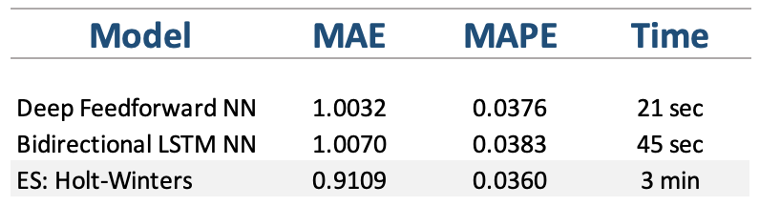

# **Preprocess**

### Import data

In [3]:
df = pd.read_csv('/content/Data_HW4.csv')
df.head()

Date/Time  Consumption (kW)
0   01/01  01:00:00         28.186119
1   01/01  02:00:00         28.136915
2   01/01  03:00:00         29.474152
3   01/01  04:00:00         29.712186
4   01/01  05:00:00         29.792711

In [4]:
# Set a date format in the index
df['month'] = df['Date/Time'].str[:3]
df['day'] = df['Date/Time'].str[4:6]
df['hour'] = df['Date/Time'].str[8:10]
df['year'] = "2021"

df["Date"] = pd.to_datetime(df[['month', 'day', 'year', 'hour']])
df.set_index('Date', inplace=True)
df = df.drop(columns=['Date/Time', 'month','day','hour','year'])

df.head()

Consumption (kW)
Date                                 
2021-01-01 01:00:00         28.186119
2021-01-01 02:00:00         28.136915
2021-01-01 03:00:00         29.474152
2021-01-01 04:00:00         29.712186
2021-01-01 05:00:00         29.792711

In [5]:
train = df.loc[(df.index.get_level_values(0) < '2021-10-01 01:00:00')]
valid = df.loc[(df.index.get_level_values(0) >= '2021-10-01 01:00:00') & (df.index.get_level_values(0) < '2021-12-01 01:00:00')]
test = df.loc[(df.index.get_level_values(0) >= '2021-12-01 01:00:00')]

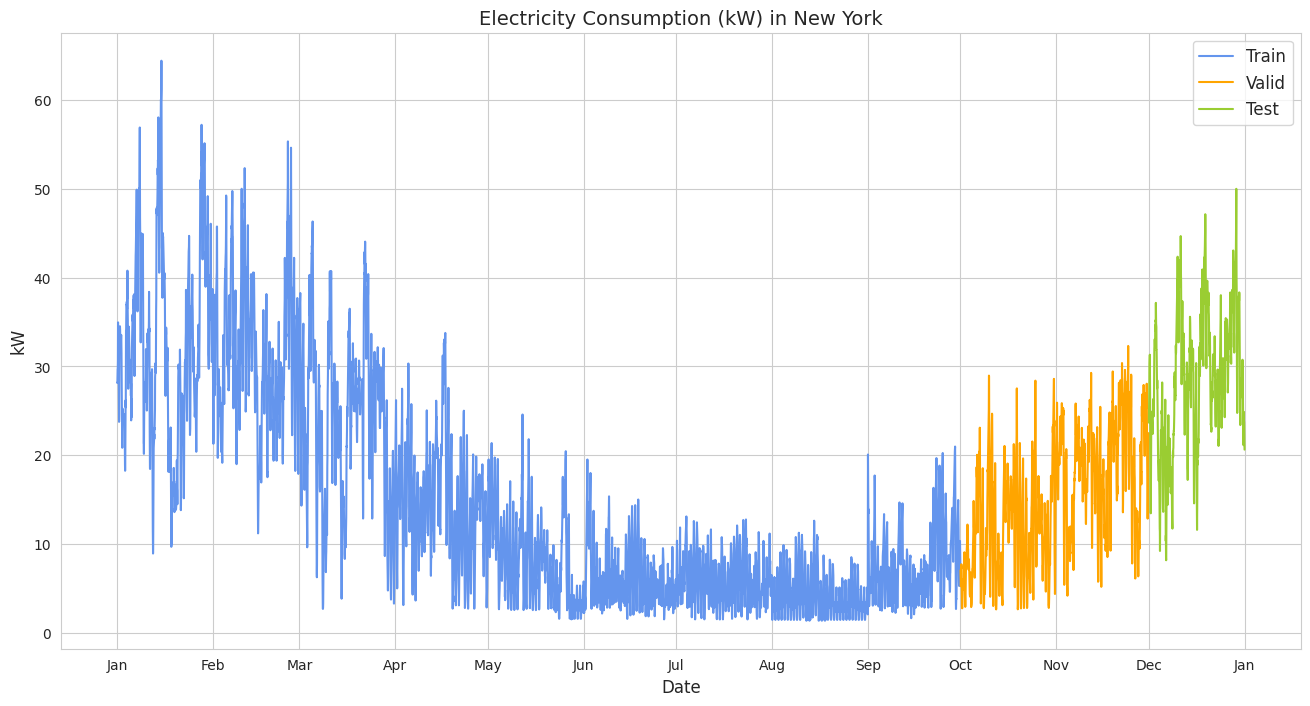

In [6]:
plt.figure(figsize = (16,8))
plt.plot(train, color='cornflowerblue', label="Train")
plt.plot(valid, color='Orange', label="Valid")
plt.plot(test, color='YellowGreen',label="Test")
plt.xlabel('Date', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('Electricity Consumption (kW) in New York', size = 14)
plt.legend(loc = 'upper right', fontsize="12")

locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)

plt.show()

The problem is to predict the next hour (the horizon) for each 1 hour step size, with a history of 11 months (I split my history with 9 months training set and 2 months validation set).

The time series are non-stationary. We can see a trend and a 24 hoursseasonality.

### Correlation

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


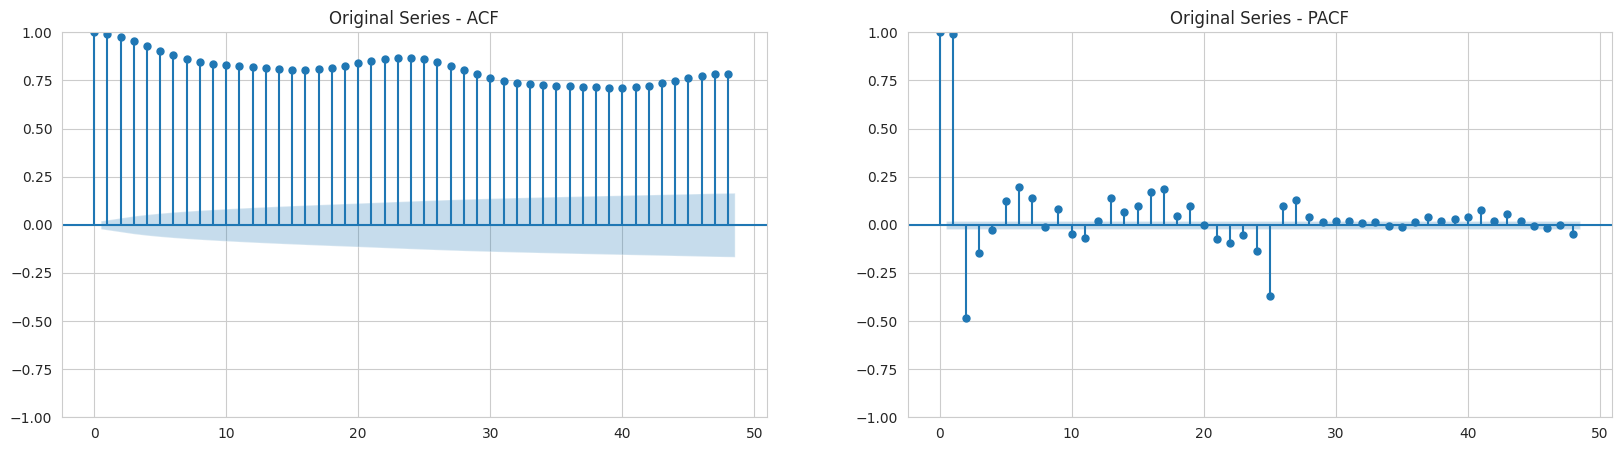

In [24]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(df, lags=48, title='Original Series - ACF', ax=ax[0])
plot_pacf(df, lags=48, title='Original Series - PACF', ax=ax[1])
plt.show()

To cheack the seasonality, I find it easier to evaluate the ACF & PACF graphs when the series are stationary. Let's try with the order of first differences.

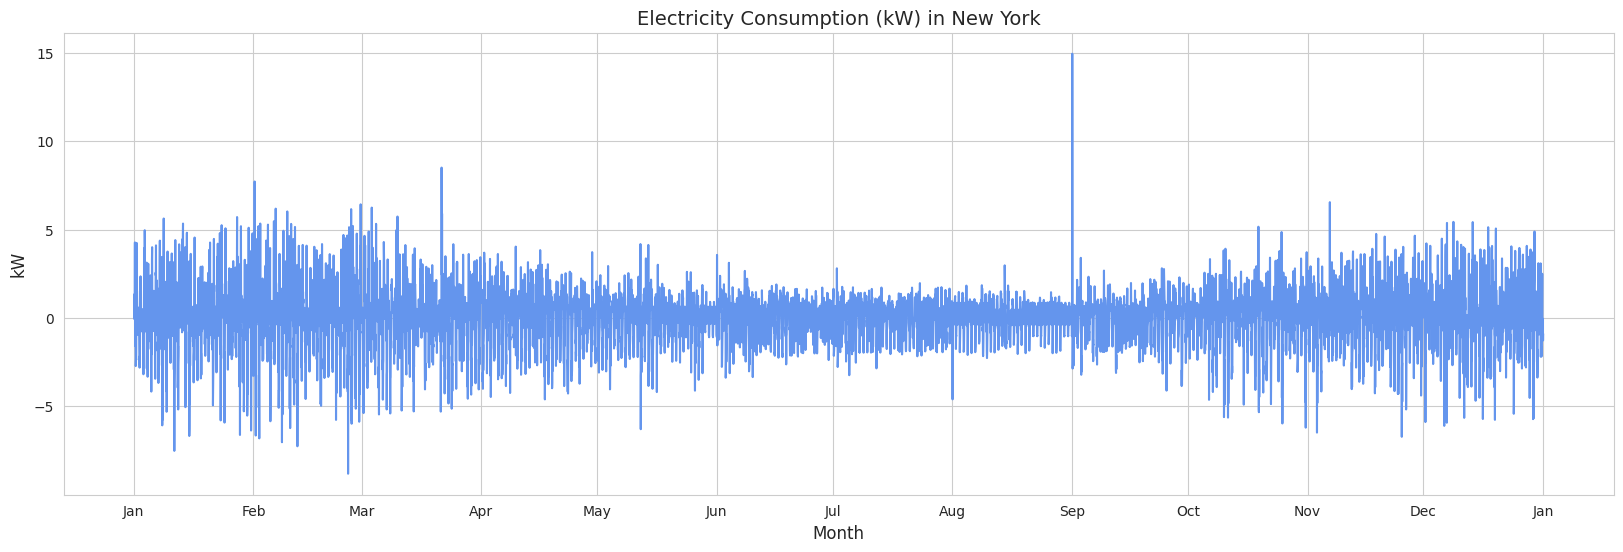

In [25]:
plt.figure(figsize = (20,6))
plt.plot(df.diff().dropna(), color='cornflowerblue')
plt.xlabel('Month', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('Electricity Consumption (kW) in New York', size = 14)

locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


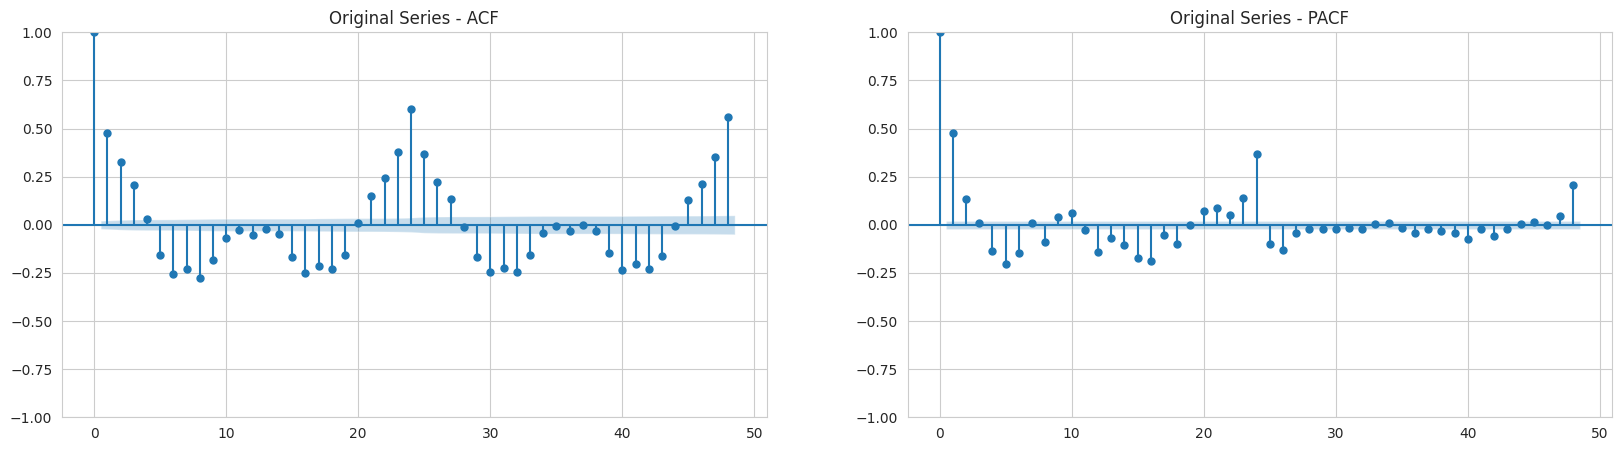

In [26]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(df.diff().dropna(), lags=48, title='Original Series - ACF', ax=ax[0])
plot_pacf(df.diff().dropna(), lags=48, title='Original Series - PACF', ax=ax[1])
plt.show()

With the order of first differences, the series are stationary and we can notice a 24 hours seasonality. PACF also helps to understanding the direct relastionship between an observation and it's specific lagged values. We can remark after 26 lags, the relationship is low.

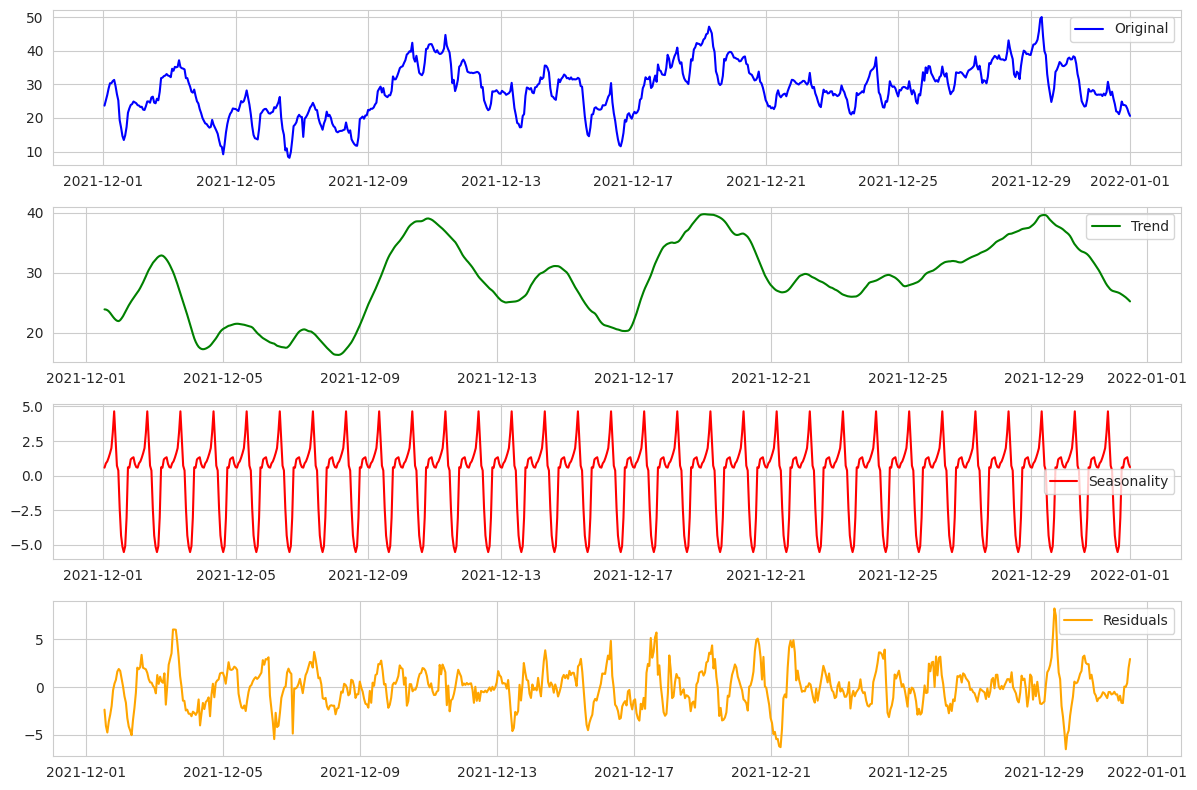

In [27]:
# Graph of decomposition (trend, seasonal, noise)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Consumption (kW)'].tail(31*24), model='add',period= 24)

# get the trend, seasonality and noise
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Consumption (kW)'].tail(31*24), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="orange")
plt.legend(loc='best')
plt.tight_layout()

### Hyperparameter Optimization Methods

We can use different techniques for hyperparameter optimization:



**1.   Grid Search / Random Search:** Use a search space defined as a delimited domain of hyperparameter values and evaluated randomly or at each grid position. For these technique, it's necessary to use cross-validation for time series, which increases the computation time.

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

**2.   Bayesian Optimization:**


*   Select a sample by optimizing the acquisition function
*   Evaluate the sample with the objective function
*   Update the data and, consequently, the surrogate function.
*   Go to step 1

https://machinelearningmastery.com/what-is-bayesian-optimization/

https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1


**3.   Iteration:** The principle is to iteratively tuning the hyperparameter of the model to find the best combination. I choose this method, which require less computation time. I adjusted the pipeline capacity to play on the bias and variance according to the graph of loss function (RMSE).



**k-Fold Cross-Validation for time series:**

In [28]:
p=1
df_lag = pd.concat([train,test])
l = list(range(1, p+1))
for i in l:
    df_lag[f'lag_{i}'] = df_lag['Consumption (kW)'].shift(i)

h=1
for i in range(0, h):
    df_lag[f'out_{i}'] = df_lag['Consumption (kW)'].shift(-i)

df_lag = df_lag.drop('Consumption (kW)',axis=1)

train_ml = df_lag.loc[(df_lag.index.get_level_values(0) < '2021-12-01 01:00:00')]
test_ml = df_lag.loc[(df_lag.index.get_level_values(0) >= '2021-12-01 01:00:00')]

train_ml_copy = train_ml.copy()
train_ml_copy.dropna(axis=0, inplace=True)
test_ml_copy = test_ml.copy()
test_ml_copy.dropna(axis=0, inplace=True)

train_ml_X = train_ml_copy[[x for x in list(train_ml_copy) if 'lag' in x]]
train_ml_Y = train_ml_copy[[x for x in list(train_ml_copy) if 'out' in x]]
test_ml_X = test_ml_copy[[x for x in list(test_ml_copy) if 'lag' in x]]
test_ml_Y = test_ml_copy[[x for x in list(test_ml_copy) if 'out' in x]]

In [29]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""

    fig, ax = plt.subplots(1, 1, figsize = (8, 4))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii+0.5] * len(indices),
                   c=indices, marker='_', lw=12, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))

    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)

    ax.set(yticks=np.arange(n_splits) +0.5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(0.85)), Patch(color=cmap_cv(.15))],
              ['Valid set', 'Train set'], loc=(0.812, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

In [30]:
df_with_index_as_column = train_ml_X.reset_index()
df_with_index_as_column['Date'] = pd.to_datetime(df_with_index_as_column['Date'])
df_with_index_as_column['Month'] = df_with_index_as_column['Date'].dt.month_name().str[:3]

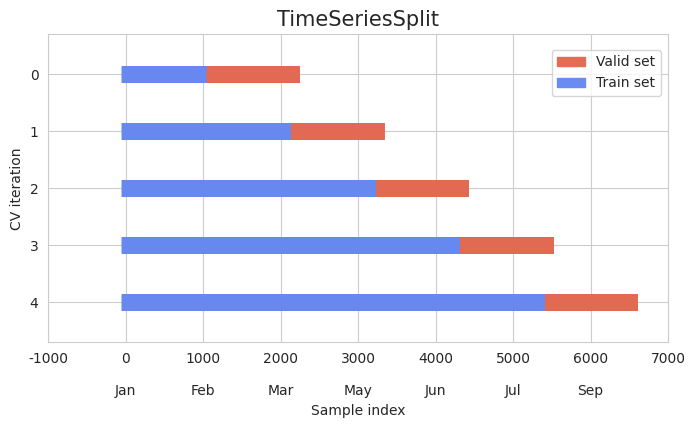

In [31]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
from matplotlib.patches import Patch

n_splits = 5

# Initialize the cross-validation splitter
tscv = TimeSeriesSplit(n_splits=n_splits)

# Train Dataframe  with my Lag
X = train_ml_X.values
y = train_ml_Y.values

for train_index, test_index in tscv.split(X):
    # Split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#plot_cv_indices(tscv, n_splits, train_ml_X, train_ml_Y, date_col = None)#df_with_index_as_column['Date'])
plot_cv_indices(tscv, n_splits, X, y, date_col = df_with_index_as_column['Month'])

### MinMax Scaler

In [128]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
valid_sc = sc.transform(valid)
test_sc = sc.transform(test)

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
valid_sc_df = pd.DataFrame(valid_sc, columns=['Scaled'], index=valid.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

In [129]:
train_sc_df.describe()

Scaled
count  6552.000000
mean      0.214986
std       0.197856
min       0.000000
25%       0.056382
50%       0.135749
75%       0.354808
max       1.000000

### Function for graph, lags, RMSE, History

In [14]:
def history_graph():

  #plt.figure(figsize=(8,3))
  plt.figure(figsize=(8,3))
  plt.plot(history.history['loss'], label='Training')
  plt.plot(history.history['val_loss'], label='Valuation')
  plt.title('Loss: ' + str(title), fontsize=18)
  plt.grid(True)
  plt.legend(fontsize=12)

In [15]:
def create_lag(lags, train_tb, valid_tb, test_tb, kind=None, scale=None):

    global train_ml_X, train_ml_Y, valid_ml_X, valid_ml_Y, test_ml_X, test_ml_Y, train_ml_X_rs, valid_ml_X_rs, test_ml_X_rs, df_lag

    p = lags
    df_lag = pd.concat([train_tb, valid_tb, test_tb])
    l = list(range(1, p+1))
    for i in l:
      if scale == "yes":
        df_lag[f'lag_{i}'] = df_lag['Scaled'].shift(i)
      else:
        df_lag[f'lag_{i}'] = df_lag['Consumption (kW)'].shift(i)

    h=1
    for i in range(0, h):
      if scale == "yes":
        df_lag[f'out_{i}'] = df_lag['Scaled'].shift(i)
      else:
        df_lag[f'out_{i}'] = df_lag['Consumption (kW)'].shift(i)

    if scale == "yes":
        df_lag = df_lag.drop('Scaled',axis=1)
    else:
        df_lag = df_lag.drop('Consumption (kW)',axis=1)


    train_ml = df_lag.loc[(df_lag.index.get_level_values(0) < '2021-10-01 01:00:00')]
    valid_ml = df_lag.loc[(df_lag.index.get_level_values(0) >= '2021-10-01 01:00:00')
                          & (df_lag.index.get_level_values(0) < '2021-12-01 01:00:00')]
    test_ml = df_lag.loc[(df_lag.index.get_level_values(0) >= '2021-12-01 01:00:00')]

    train_ml_copy = train_ml.copy()
    train_ml_copy.dropna(axis=0, inplace=True)
    valid_ml_copy = valid_ml.copy()
    valid_ml_copy.dropna(axis=0, inplace=True)
    test_ml_copy = test_ml.copy()
    test_ml_copy.dropna(axis=0, inplace=True)

    train_ml_X = train_ml_copy[[x for x in list(train_ml_copy) if 'lag' in x]]
    train_ml_Y = train_ml_copy[[x for x in list(train_ml_copy) if 'out_0' in x]]
    valid_ml_X = valid_ml_copy[[x for x in list(valid_ml_copy) if 'lag' in x]]
    valid_ml_Y = valid_ml_copy[[x for x in list(valid_ml_copy) if 'out_0' in x]]
    test_ml_X = test_ml_copy[[x for x in list(test_ml_copy) if 'lag' in x]]
    test_ml_Y = test_ml_copy[[x for x in list(test_ml_copy) if 'out_0' in x]]

    if kind == 'LSTM':
      train_ml_X = train_ml_X.values
      valid_ml_X = valid_ml_X.values
      test_ml_X = test_ml_X.values

      train_ml_X_rs = train_ml_X.reshape(train_ml_X.shape[0], 1, p)
      valid_ml_X_rs = valid_ml_X.reshape(valid_ml_X.shape[0], 1, p)
      test_ml_X_rs = test_ml_X.reshape(test_ml_X.shape[0], 1, p)

      return train_ml_X_rs, train_ml_Y, valid_ml_X_rs, valid_ml_Y, test_ml_X_rs, test_ml_Y

    else:
      return train_ml_X, train_ml_Y, valid_ml_X, valid_ml_Y, test_ml_X, test_ml_Y

In [16]:
create_lag(30, train, valid, test)
print(train_ml_X.shape)
print(train_ml_Y.shape)
print(valid_ml_X.shape)
print(valid_ml_Y.shape)
print(test_ml_X.shape)
print(test_ml_Y.shape)
print(df_lag.shape)

(6522, 30)
(6522, 1)
(1464, 30)
(1464, 1)
(744, 30)
(744, 1)
(8760, 31)


**How to choose loss functions when training DL NN**

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

**How to use Learning Curves to diagnose ML model performance:**

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [17]:
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [18]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [20]:
def history_df(tbl):

  global dfh
  dfh = pd.DataFrame()

  for i, history in enumerate(history_list):

      temp_df = pd.DataFrame(history.history)
      temp_df['Iteration'] = i+1
      dfh = pd.concat([dfh, temp_df])

  dfh.rename(columns={'index': 'Epoch'}, inplace=True)

  return dfh

# **DNN**

### Number of Lags

24/24 [==============================] - 0s 1ms/step
Lags = 6 ,MAE = 1.348118447765784, MAPE = 0.04969016800674823


24/24 [==============================] - 0s 939us/step
Lags = 12 ,MAE = 1.1620289684576737, MAPE = 0.04322024279166235


24/24 [==============================] - 0s 873us/step
Lags = 24 ,MAE = 1.2358838984291842, MAPE = 0.04700863229360878


24/24 [==============================] - 0s 985us/step
Lags = 30 ,MAE = 1.0680763573305578, MAPE = 0.0401032463863406


24/24 [==============================] - 0s 888us/step
Lags = 36 ,MAE = 1.3951800225772548, MAPE = 0.05064510406736143


24/24 [==============================] - 0s 1ms/step
Lags = 48 ,MAE = 1.5433173727103475, MAPE = 0.05607976948610083




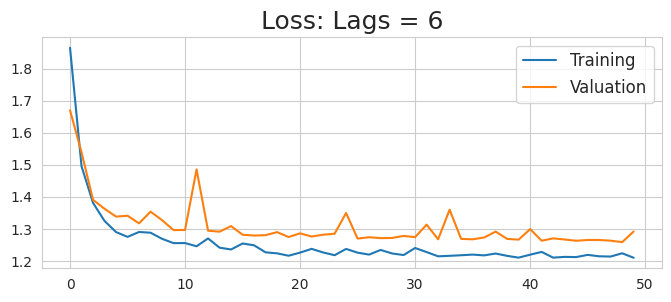

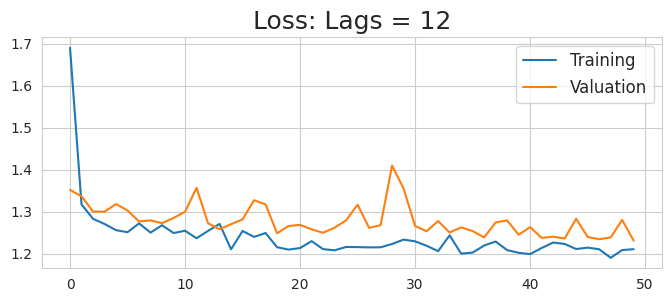

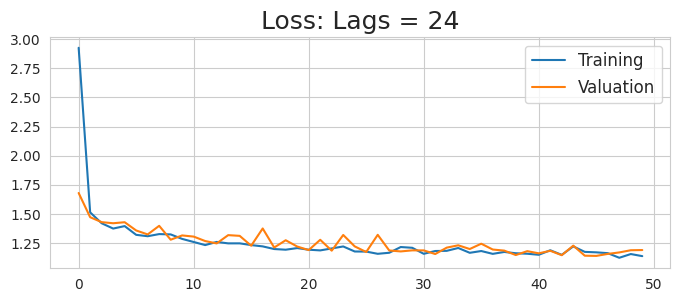

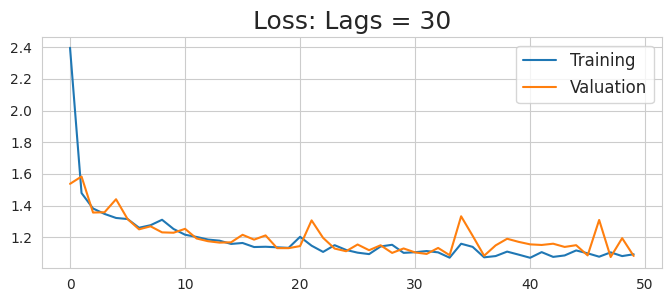

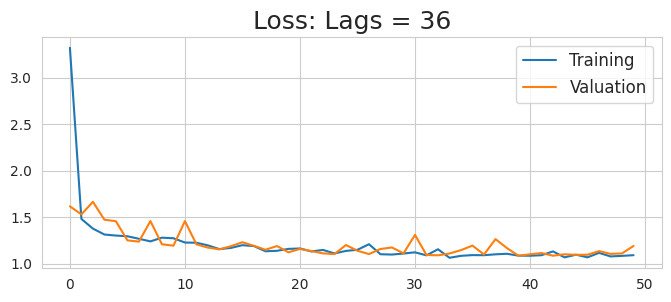

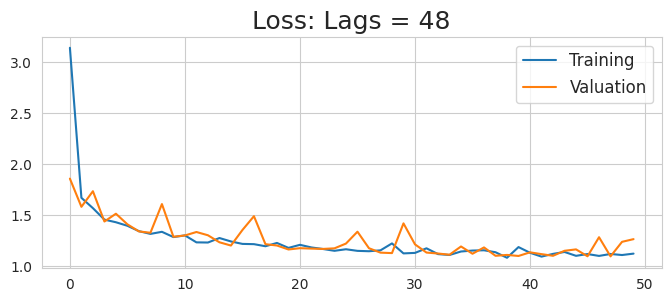

In [ ]:
history_list =[]

for p in [6, 12, 24, 30, 36, 48]:

    create_lag(p, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=p, activation='relu'))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Lags = " + str(p) + " ,MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Lags = " + str(p)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.2100797891616821 1.2921243906021118
2 1.2109471559524536 1.2312843799591064
3 1.138443946838379 1.190700888633728
4 1.0924177169799805 1.0816049575805664
5 1.0938374996185303 1.1932785511016846
6 1.1236032247543335 1.265455961227417


### Activation

24/24 [==============================] - 0s 918us/step
Activation = softplus, MAE = 1.062187398816695, MAPE = 0.03983079298837358


24/24 [==============================] - 0s 876us/step
Activation = relu, MAE = 1.0680763573305578, MAPE = 0.0401032463863406


24/24 [==============================] - 0s 884us/step
Activation = linear, MAE = 1.1855876574844502, MAPE = 0.04377012789865257




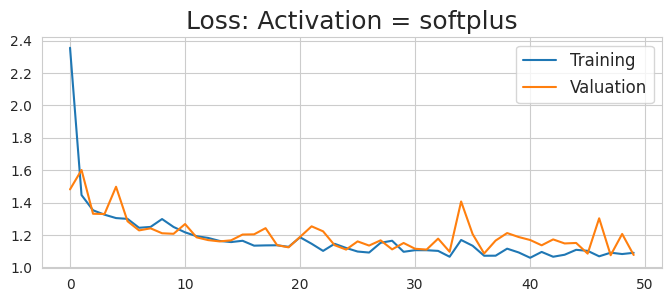

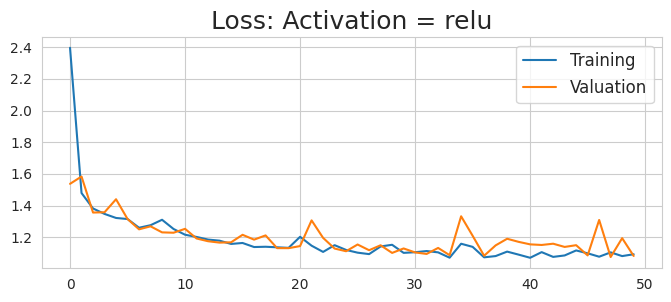

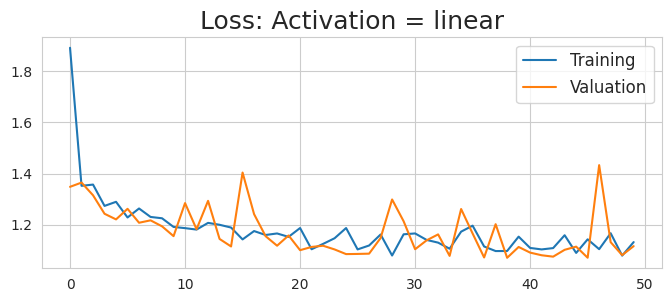

In [ ]:
history_list =[]
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
activation = ['softplus', 'relu', 'linear']

for a in activation:

    create_lag(30, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30, activation=a))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Activation = " + str(a) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Activation = " + str(a)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.0903733968734741 1.0768117904663086
2 1.0924177169799805 1.0816049575805664
3 1.1320000886917114 1.1162272691726685


### BatchNormalization

24/24 [==============================] - 0s 2ms/step
BatchNormalization , MAE = 1.13199290027805, MAPE = 0.04258105604229207




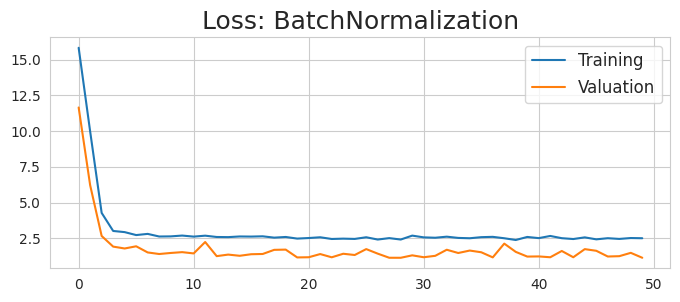

In [ ]:
history_list =[]

create_lag(30, train, valid, test)

model = Sequential()
model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30, activation="softplus"))
model.add(BatchNormalization())
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer='adam')

history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

history_list.append(history)

y_pred = model.predict(test_ml_X)
testTxt = ("BatchNormalization " + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
title = "BatchNormalization"

print(testTxt)
history_graph()
print('\n')

In [ ]:
history_df(history_list)

for i in [1]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 2.5069451332092285 1.1403616666793823


### MinMax Scaler

24/24 [==============================] - 0s 874us/step
MinMax Scaler, MAE = 1.0834393903663253, MAPE = 0.04055819018739025




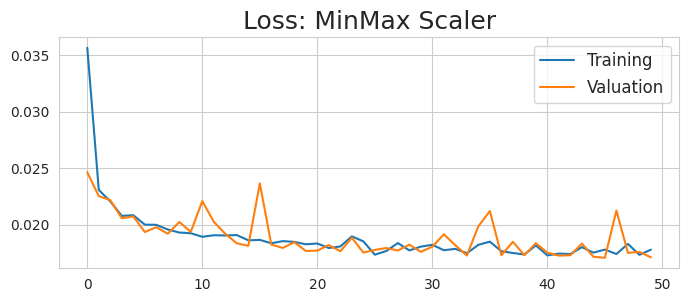

In [104]:
history_list =[]

create_lag(30, train_sc_df, valid_sc_df, test_sc_df, scale="yes")

model = Sequential()
model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30, activation="softplus"))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer='adam')

history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

history_list.append(history)

y_pred = model.predict(test_ml_X)
test_ml_Y_rv = sc.inverse_transform(test_ml_Y)
y_pred = sc.inverse_transform(y_pred)
testTxt = ("MinMax Scaler" + ", MAE = " + str(mean_absolute_error(test_ml_Y_rv, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y_rv, y_pred)))
title = "MinMax Scaler"

print(testTxt)
history_graph()
print('\n')

In [84]:
history_df(history_list)

for i in [1]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 0.017803112044930458 0.01712917350232601


### Dropout

24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.0, MAE = 1.062187398816695, MAPE = 0.03983079298837358


24/24 [==============================] - 0s 2ms/step
Dropout_rate = 0.2, MAE = 1.3111029553101794, MAPE = 0.047310195793198236


24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.4, MAE = 1.5050440785696537, MAPE = 0.05313296670491983


24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.6, MAE = 2.483681953126131, MAPE = 0.08315085473281572


24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.8, MAE = 5.75056151059652, MAPE = 0.1905457869013009




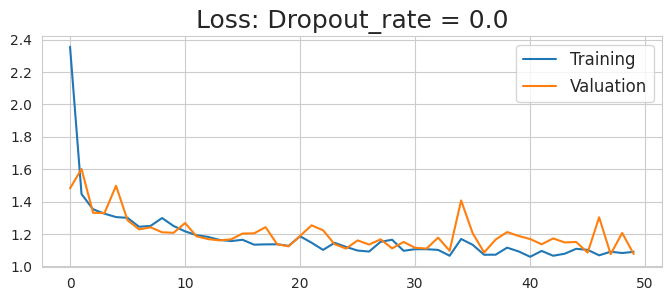

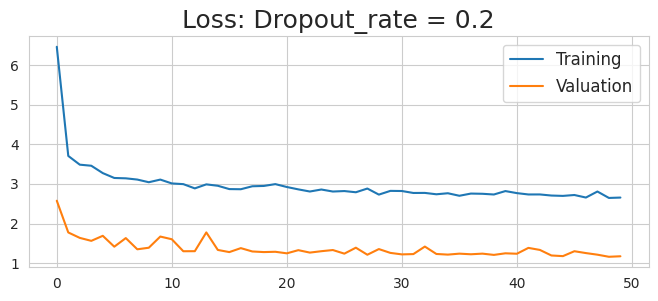

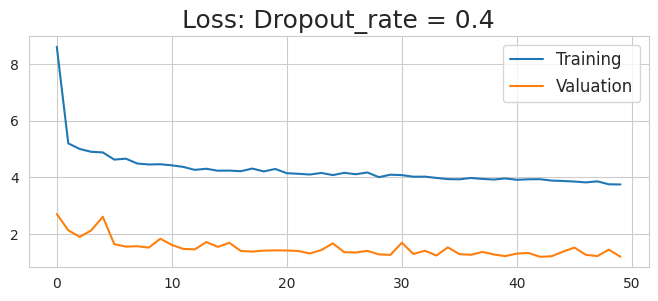

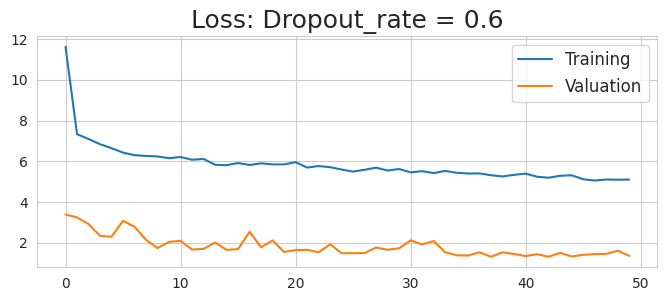

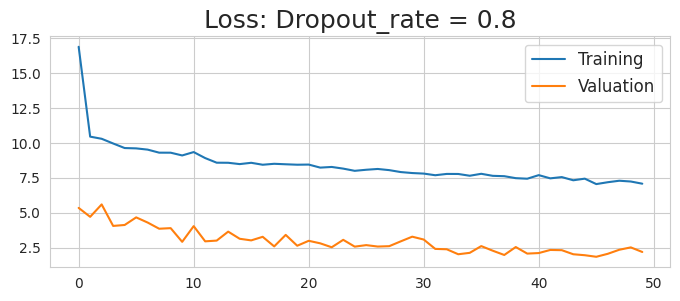

In [ ]:
history_list =[]
Dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]

for d in Dropout_rate:

    create_lag(30, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30, activation="softplus"))
    model.add(Dropout(d))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Dropout_rate = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Dropout_rate = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3,4,5]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.0903733968734741 1.0768117904663086
2 2.6554300785064697 1.1730343103408813
3 3.7533342838287354 1.201896071434021
4 5.105839252471924 1.3636856079101562
5 7.085316181182861 2.19925856590271


### Layer Regularization

24/24 [==============================] - 0s 1ms/step
Regularizers = 0.001, MAE = 1.0695638336371862, MAPE = 0.04015340189209879


24/24 [==============================] - 0s 2ms/step
Regularizers = 0.01, MAE = 1.0488793020643987, MAPE = 0.039529713359518305


24/24 [==============================] - 0s 1ms/step
Regularizers = 0.05, MAE = 1.051125064531046, MAPE = 0.03973530276176871


24/24 [==============================] - 0s 1ms/step
Regularizers = 0.08, MAE = 1.0538327796431242, MAPE = 0.03982675342618104


24/24 [==============================] - 0s 1ms/step
Regularizers = 0.09, MAE = 1.055901255850416, MAPE = 0.039891058437872086


24/24 [==============================] - 0s 2ms/step
Regularizers = 1, MAE = 1.8581694499287207, MAPE = 0.06559493407734823




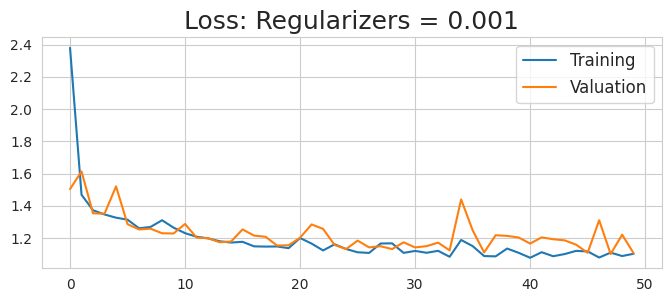

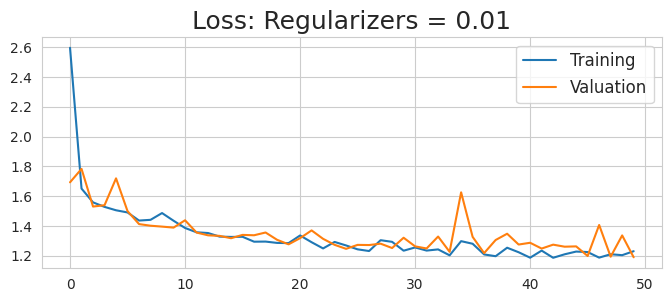

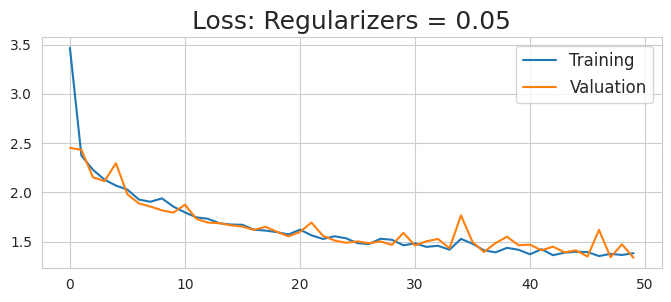

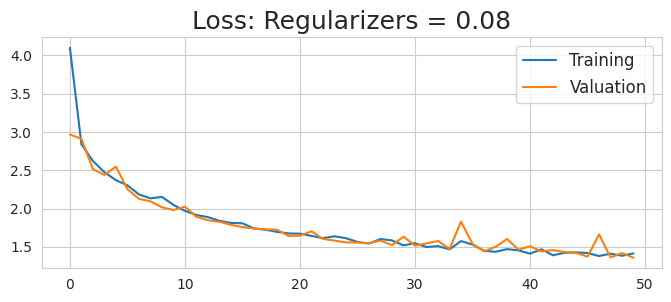

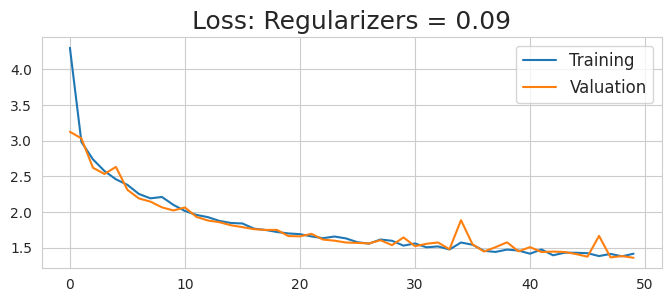

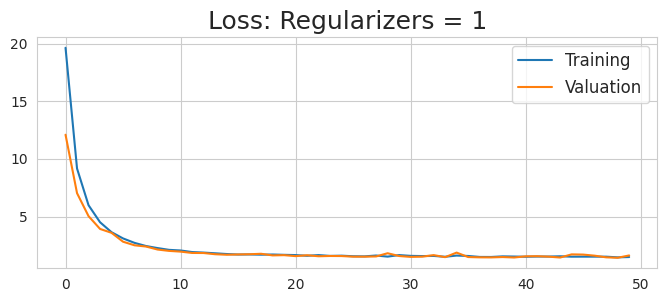

In [ ]:
history_list =[]

for r in [0.001, 0.01, 0.05, 0.08, 0.09, 1]:

    create_lag(30, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(r)))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Regularizers = " + str(r) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Regularizers = " + str(r)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.103385090827942 1.1056848764419556
2 1.2303781509399414 1.189571738243103
3 1.3831474781036377 1.3365230560302734
4 1.4161412715911865 1.3583787679672241
5 1.4188677072525024 1.361703634262085
6 1.4938384294509888 1.6327179670333862


### Training Optimization

24/24 [==============================] - 0s 962us/step
Optimizer = Adagrad, MAE = 1.428650339792064, MAPE = 0.05391505954237874


24/24 [==============================] - 0s 983us/step
Optimizer = Adam, MAE = 1.0695638336371862, MAPE = 0.04015340189209879




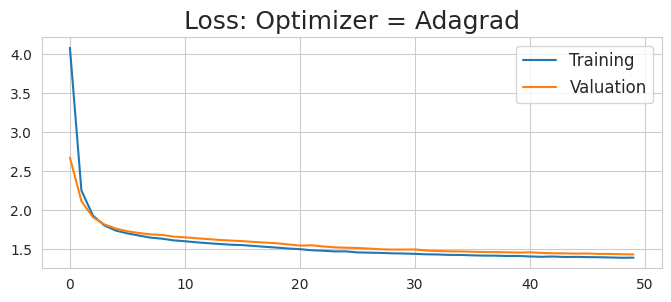

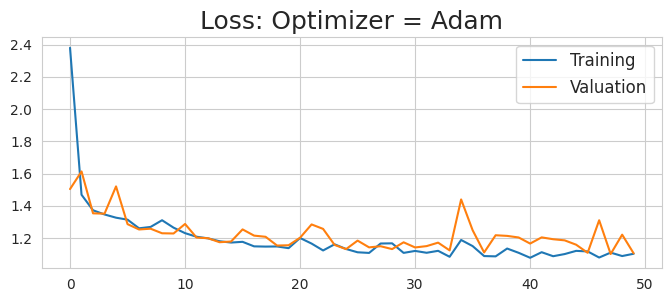

In [18]:
history_list =[]
optimizer = ['Adagrad', 'Adam']

for opt in optimizer:

    create_lag(30, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=opt)

    history=model.fit(train_ml_X, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Optimizer = " + str(opt) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Optimizer = " + str(opt)

    print(testTxt)
    history_graph()
    print('\n')

In [19]:
history_df(history_list)

for i in [1,2]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.3910986185073853 1.4325759410858154
2 1.103385090827942 1.1056848764419556


### Batch Size & Epochs

24/24 [==============================] - 0s 952us/step
batch_size = 32, epochs = 30, MAE = 1.1394377593113292, MAPE = 0.04247279830231282


24/24 [==============================] - 0s 1ms/step
batch_size = 32, epochs = 50, MAE = 1.0695638336371862, MAPE = 0.04015340189209879


24/24 [==============================] - 0s 1ms/step
batch_size = 32, epochs = 120, MAE = 1.0319815921255928, MAPE = 0.038932591970026964


24/24 [==============================] - 0s 926us/step
batch_size = 64, epochs = 30, MAE = 1.0996801512627938, MAPE = 0.041346352068851365


24/24 [==============================] - 0s 850us/step
batch_size = 64, epochs = 50, MAE = 1.0580497861376061, MAPE = 0.03992662078168971


24/24 [==============================] - 0s 874us/step
batch_size = 64, epochs = 120, MAE = 1.0524808721515673, MAPE = 0.03943565236767197


24/24 [==============================] - 0s 985us/step
batch_size = 128, epochs = 30, MAE = 1.1975620010991146, MAPE = 0.0452621043327676


24/24 [=============

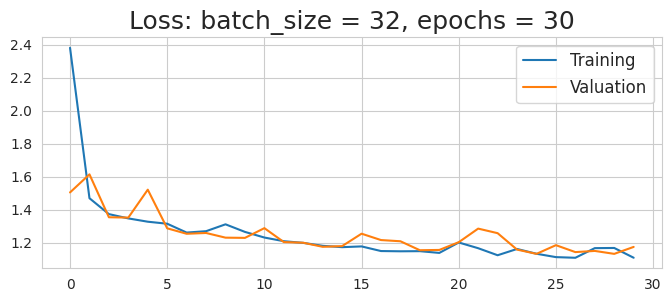

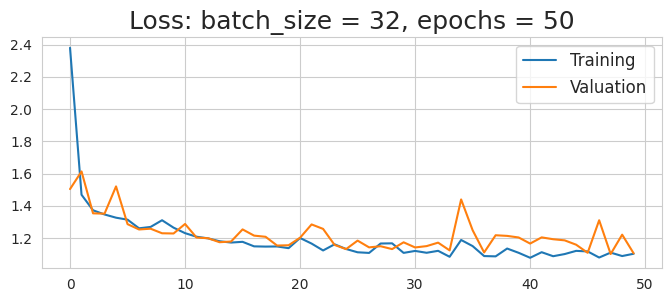

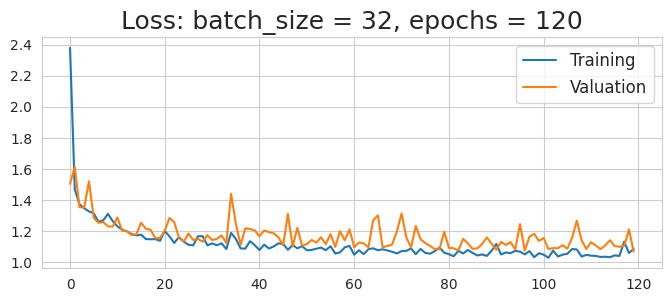

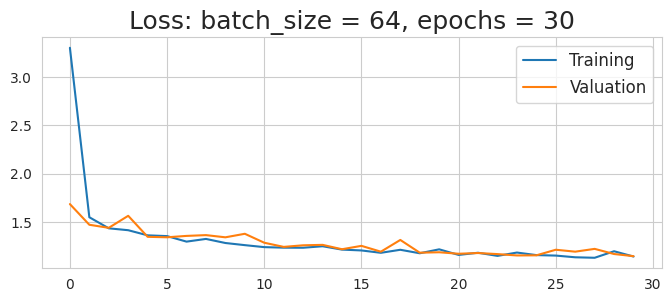

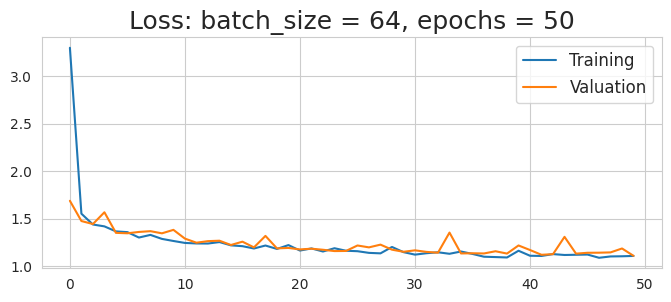

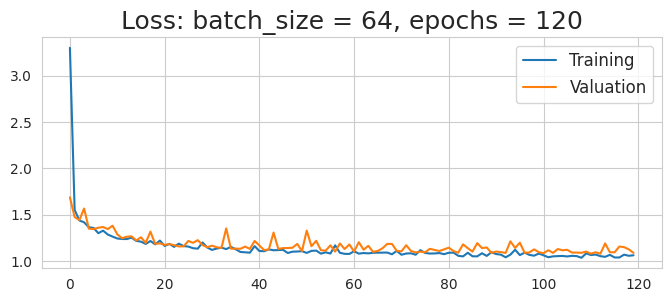

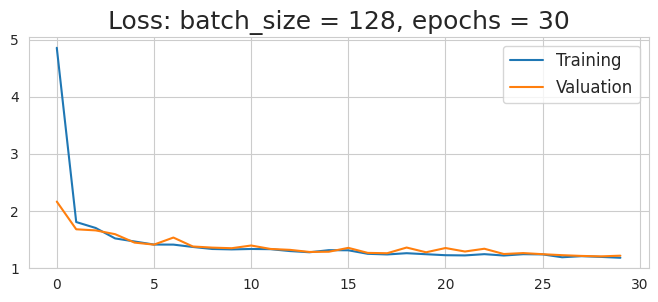

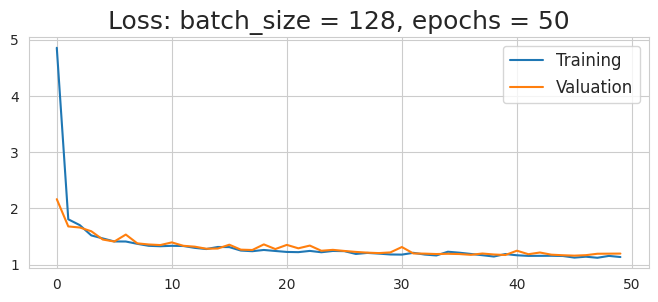

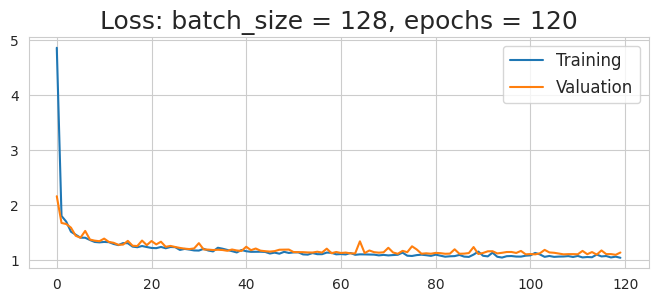

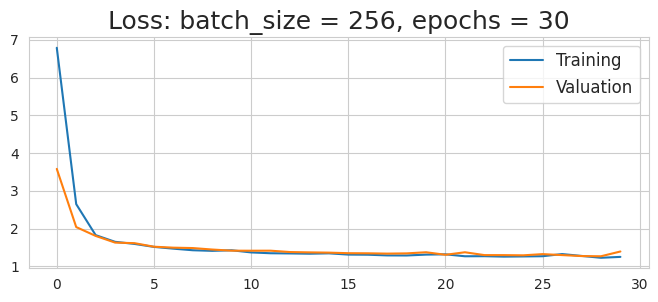

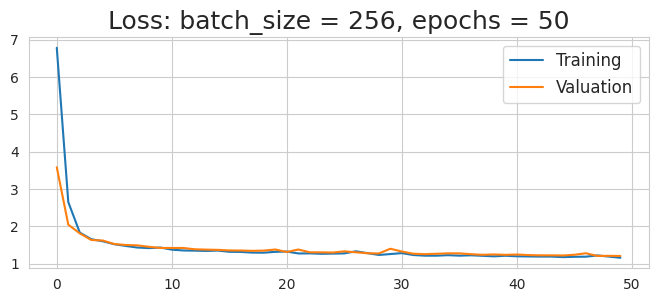

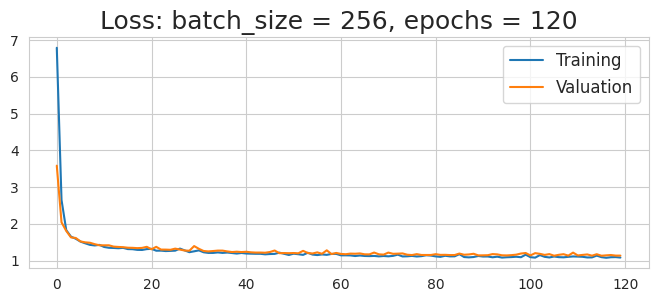

In [20]:
batch_size = [32, 64, 128, 256]
epochs = [30, 50, 120]
history_list =[]

for i, j in itertools.product(batch_size, epochs):

    create_lag(30, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer="Adam")

    history=model.fit(train_ml_X, train_ml_Y, epochs=j,
                batch_size=i, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("batch_size = " + str(i) + ", epochs = " + str(j) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "batch_size = " + str(i) + ", epochs = " + str(j)

    print(testTxt)
    history_graph()
    print('\n')

In [21]:
history_df(history_list)

for i,j in [1,29],[2,49],[3,119],[4,29],[5,49],[6,119],[7,29],[8,49],[9,119],[10,29],[11,49],[12,119]:#, [13,29],[14,49],[15,119]:
    print(i, dfh["loss"].loc[dfh['Iteration'] == i][j], dfh["val_loss"].loc[dfh['Iteration'] == i][j])

1 1.1087356805801392 1.1743053197860718
2 1.103385090827942 1.1056848764419556
3 1.085365891456604 1.0689082145690918
4 1.1475069522857666 1.151321291923523
5 1.1075423955917358 1.1086300611495972
6 1.063442587852478 1.0889664888381958
7 1.1810177564620972 1.2176393270492554
8 1.1354070901870728 1.1967135667800903
9 1.0478860139846802 1.1431384086608887
10 1.2538923025131226 1.3964364528656006
11 1.1542593240737915 1.203080415725708
12 1.084349513053894 1.1373085975646973


### Learning Rate

24/24 [==============================] - 0s 965us/step
learn_rate = 0.0005, MAE = 1.0448817881373984, MAPE = 0.039554308117811424


24/24 [==============================] - 0s 898us/step
learn_rate = 0.001, MAE = 1.0524808721515673, MAPE = 0.03943565236767197


24/24 [==============================] - 0s 915us/step
learn_rate = 0.01, MAE = 1.093166787913565, MAPE = 0.04131641799956509


24/24 [==============================] - 0s 954us/step
learn_rate = 0.015, MAE = 1.0595601176959057, MAPE = 0.040038883199979274




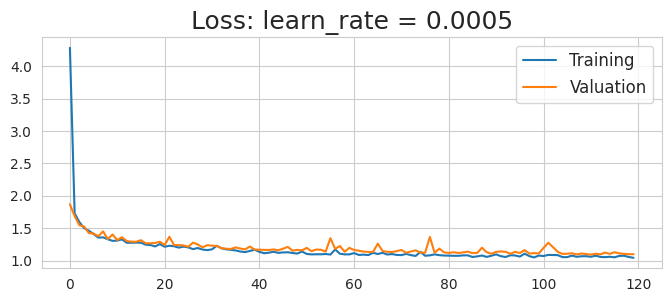

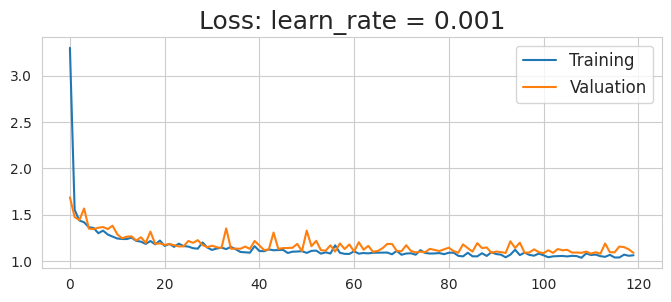

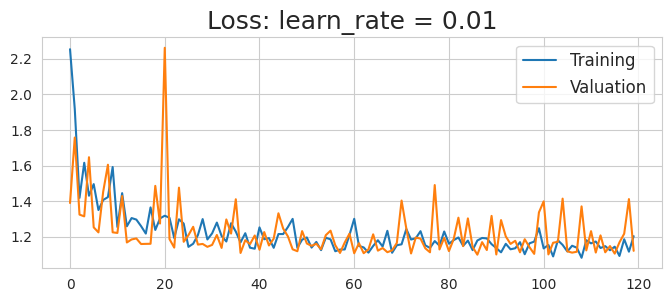

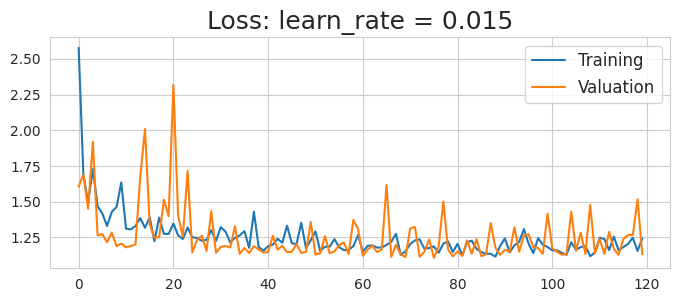

In [23]:
history_list =[]
learn_rate = [0.0005, 0.001, 0.01, 0.015]

for lr in learn_rate:

    create_lag(30, train, valid, test)

    model = Sequential()
    model.add(Dense(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    history=model.fit(train_ml_X, train_ml_Y, epochs=120,
                batch_size=64, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("learn_rate = " + str(lr) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "learn_rate = " + str(lr)

    print(testTxt)
    history_graph()
    print('\n')

In [24]:
history_df(history_list)

for i in [1,2,3,4]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 1.0423414707183838 1.0981460809707642
2 1.063442587852478 1.0889664888381958
3 1.2037919759750366 1.121408462524414
4 1.2439309358596802 1.132535457611084


### Network Topology

24/24 [==============================] - 0s 867us/step
Units = 8, MAE = 1.04273096430916, MAPE = 0.03930815760309043


24/24 [==============================] - 0s 915us/step
Units = 16, MAE = 1.0390416204803214, MAPE = 0.03897058016294442


24/24 [==============================] - 0s 906us/step
Units = 24, MAE = 1.0448817881373984, MAPE = 0.039554308117811424


24/24 [==============================] - 0s 1ms/step
Units = 30, MAE = 1.0421951191240906, MAPE = 0.03947701805916787


24/24 [==============================] - 0s 1ms/step
Units = 36, MAE = 1.003222592672827, MAPE = 0.03764215412074744


24/24 [==============================] - 0s 873us/step
Units = 48, MAE = 1.0173880080507398, MAPE = 0.03828984898378955




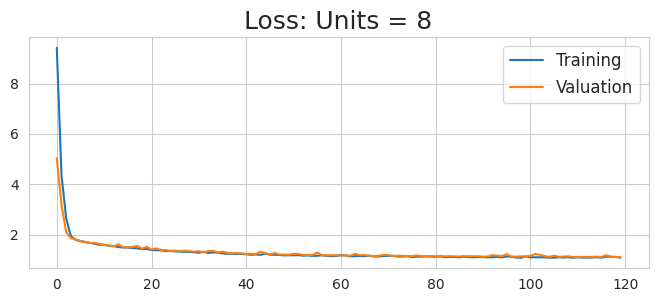

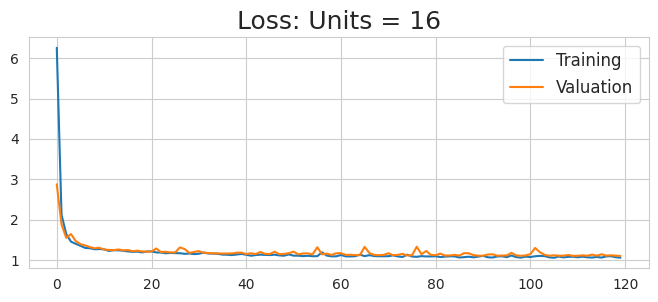

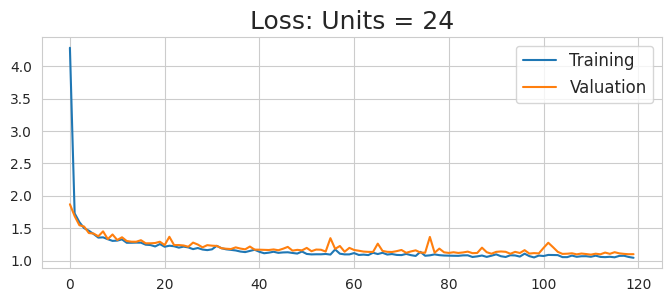

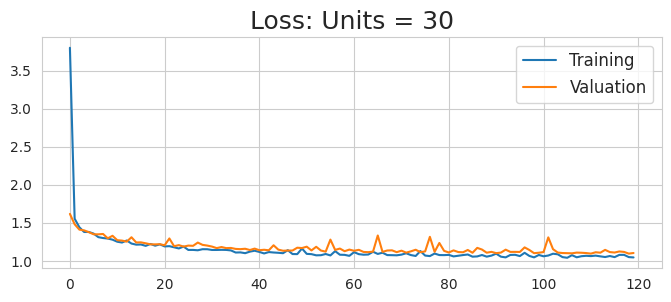

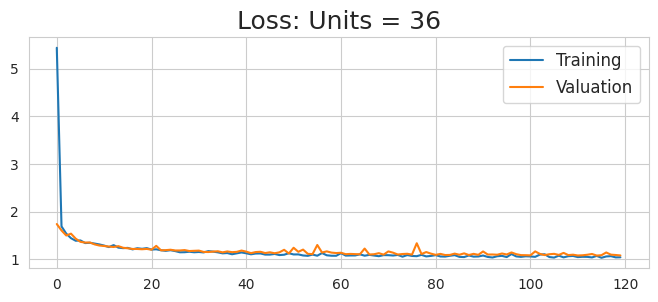

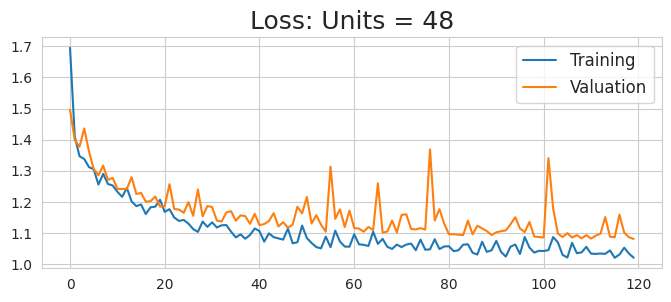

In [72]:
history_list =[]
create_lag(30, train, valid, test)

for d in [8, 16, 24, 30, 36, 48]:

    model = Sequential()
    model.add(Dense(d, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

    history=model.fit(train_ml_X, train_ml_Y, epochs=120,
                batch_size=64, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Units = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Units = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [73]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 1.0789064168930054 1.108899712562561
2 1.0557832717895508 1.100416898727417
3 1.0423414707183838 1.0981460809707642
4 1.046618103981018 1.1047403812408447
5 1.0413687229156494 1.080039381980896
6 1.0212734937667847 1.0816072225570679


24/24 [==============================] - 0s 982us/step
Units = 8, MAE = 1.0943393546264084, MAPE = 0.04040671972378709


24/24 [==============================] - 0s 917us/step
Units = 16, MAE = 1.0454458182186555, MAPE = 0.0390801443569092


24/24 [==============================] - 0s 1ms/step
Units = 24, MAE = 1.074881383784965, MAPE = 0.040191836542686536


24/24 [==============================] - 0s 867us/step
Units = 36, MAE = 1.0582694547499063, MAPE = 0.03941177698921005




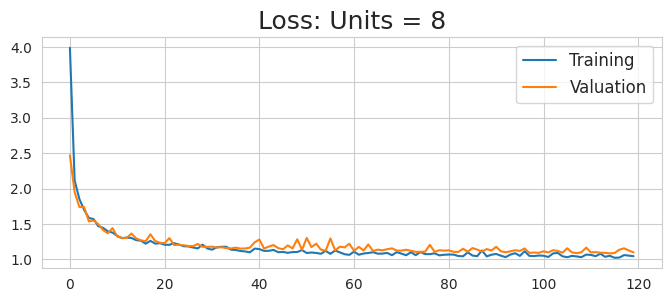

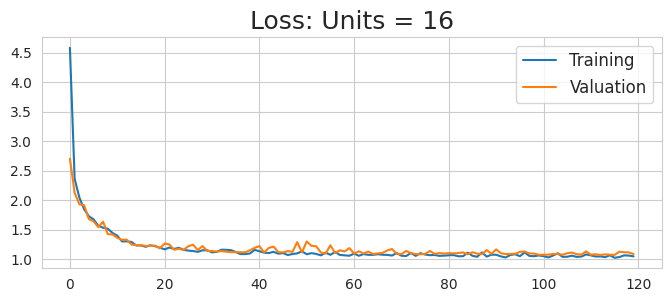

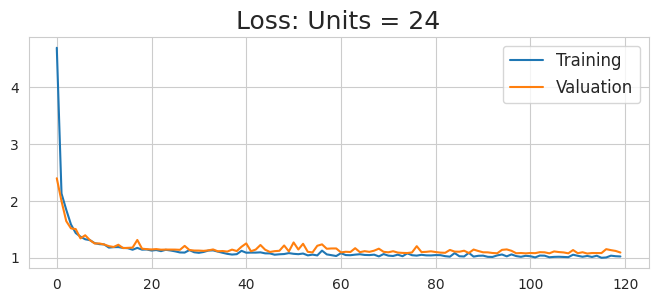

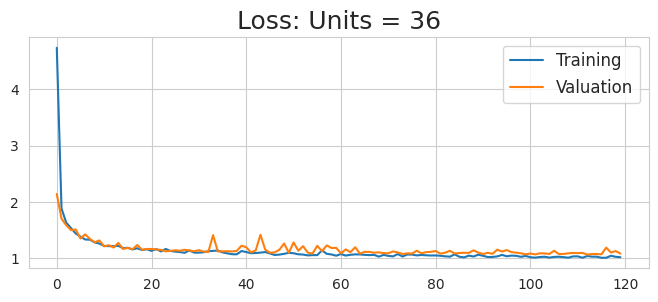

In [27]:
history_list =[]

for d in [8, 16, 24, 36]:

    model = Sequential()
    model.add(Dense(36, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(d, kernel_initializer=keras.initializers.glorot_uniform(seed=66), activation="softplus"))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

    history=model.fit(train_ml_X, train_ml_Y, epochs=120,
                batch_size=64, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X)
    testTxt = ("Units = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Units = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [28]:
history_df(history_list)

for i in [1,2,3,4]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 1.0450398921966553 1.0986942052841187
2 1.0470547676086426 1.0866544246673584
3 1.0257353782653809 1.0949599742889404
4 1.0199127197265625 1.085243821144104


### Initializers

24/24 [==============================] - 0s 925us/step
MAE = 1.0541486631875454, MAPE = 0.039276350476663426




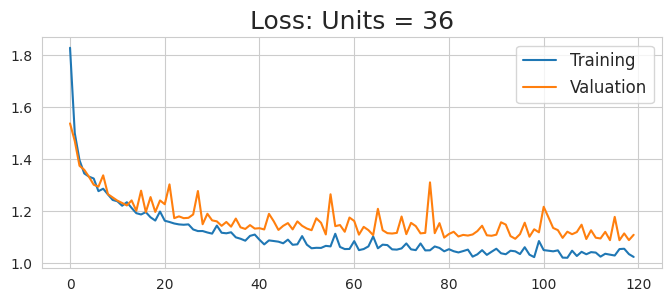

In [30]:
create_lag(30, train, valid, test)

model = Sequential()
model.add(Dense(36, kernel_initializer=keras.initializers.glorot_normal(seed=66), input_dim=30,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_normal(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

history=model.fit(train_ml_X, train_ml_Y, epochs=120,
                batch_size=64, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

y_pred = model.predict(test_ml_X)
testTxt = ("MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))

print(testTxt)
history_graph()
print('\n')

### Final DNN

In [41]:
st = time.time()
p=30
create_lag(p, train, valid, test)

model = Sequential()
model.add(Dense(36, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=p,
                    activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001)))
#model.add(Dense(36, kernel_initializer=keras.initializers.glorot_uniform(seed=66), activation="softplus"))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
#model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

history=model.fit(train_ml_X, train_ml_Y, epochs=120,
                batch_size=64, verbose=0, validation_data=(valid_ml_X, valid_ml_Y))

et = time.time()
elapsed_time = et - st

y_pred = model.predict(test_ml_X)
testTxt = ("MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))

print(testTxt)
print(timedelta(seconds=elapsed_time))
#history_graph()
print('\n')

24/24 [==============================] - 0s 4ms/step
MAE = 1.003222592672827, MAPE = 0.03764215412074744
0:00:41.743279




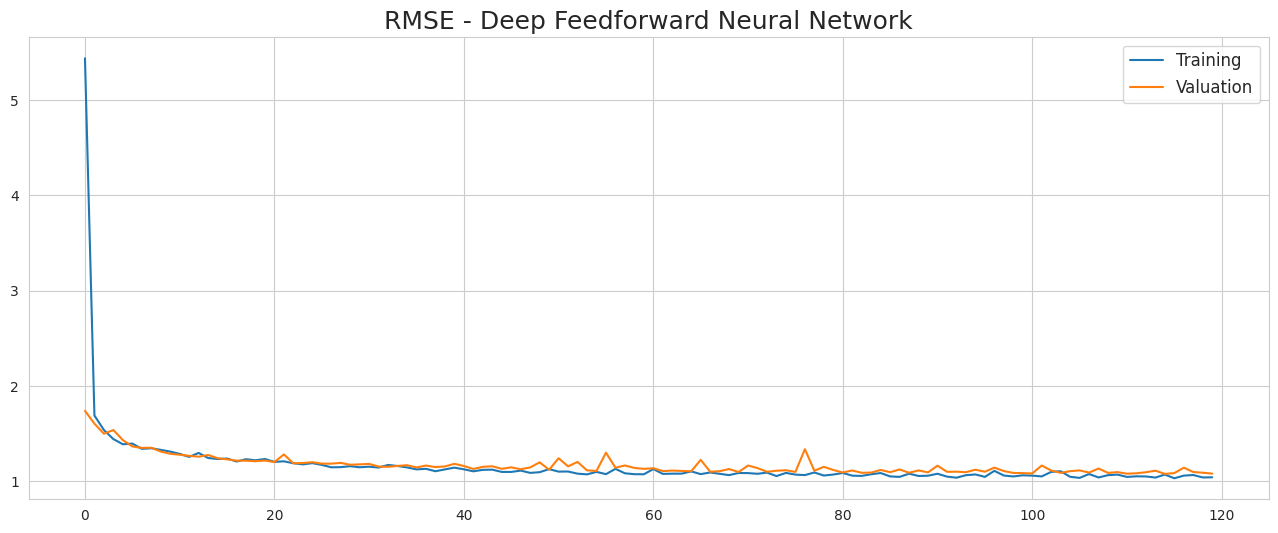

In [95]:
plt.figure(figsize=(16,6))
#plt.plot(history.history['loss'], color='cornflowerblue', label='Training')
#plt.plot(history.history['val_loss'], color='orange', label='Valuation')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Valuation')
plt.title('RMSE - Deep Feedforward Neural Network', fontsize=18)
plt.grid(True)
plt.legend(fontsize=12)

In [42]:
df_preds = test_ml_Y.copy()
df_preds[f'preds'] = y_pred
df_preds.head()

out_0      preds
Date                                     
2021-12-01 01:00:00  23.675968  23.124392
2021-12-01 02:00:00  25.239773  24.367737
2021-12-01 03:00:00  26.844480  25.756203
2021-12-01 04:00:00  28.815815  27.259325
2021-12-01 05:00:00  30.333043  29.734262

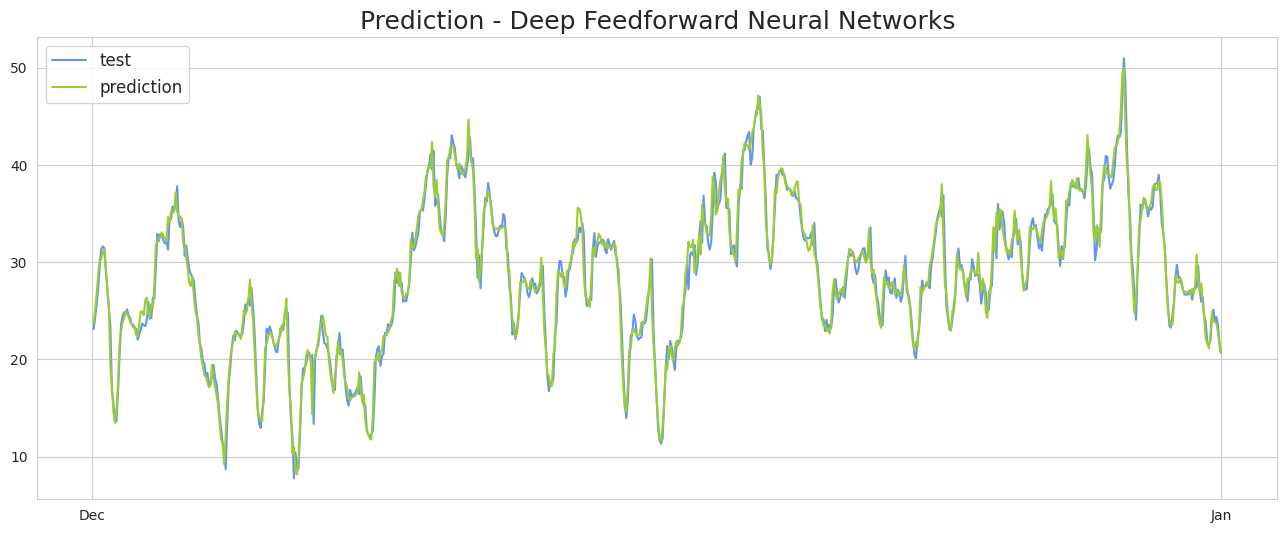

In [97]:
plt.figure(figsize=(16,6))
plt.title('Prediction - Deep Feedforward Neural Networks', fontsize=18)
plt.plot(df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

# **LSTM**

How to develop LSTM models for Time Series Forecasting

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

### Number of Lags

24/24 [==============================] - 0s 1ms/step
Lags = 6 ,MAE = 1.3549843221582853, MAPE = 0.05027392378710831


24/24 [==============================] - 0s 1ms/step
Lags = 12 ,MAE = 1.1478392388754446, MAPE = 0.04344012652624102


24/24 [==============================] - 0s 1ms/step
Lags = 24 ,MAE = 1.1529882890209078, MAPE = 0.04338358417184267


24/24 [==============================] - 0s 1ms/step
Lags = 30 ,MAE = 1.065150212261024, MAPE = 0.039904265046624456


24/24 [==============================] - 0s 1ms/step
Lags = 36 ,MAE = 1.10650434149477, MAPE = 0.04166290283041343


24/24 [==============================] - 0s 1ms/step
Lags = 48 ,MAE = 1.106359745590836, MAPE = 0.04136407059442565




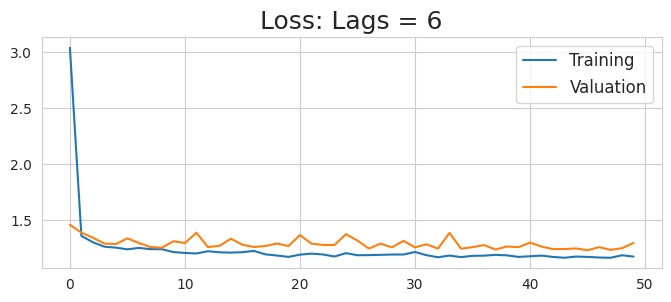

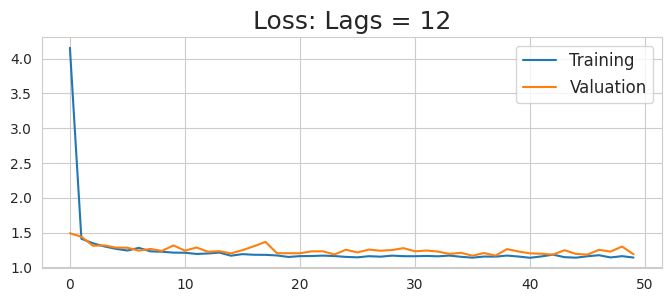

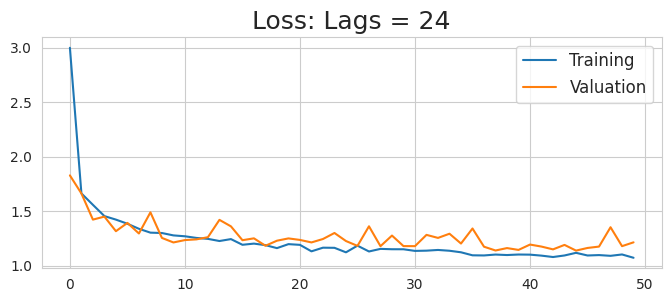

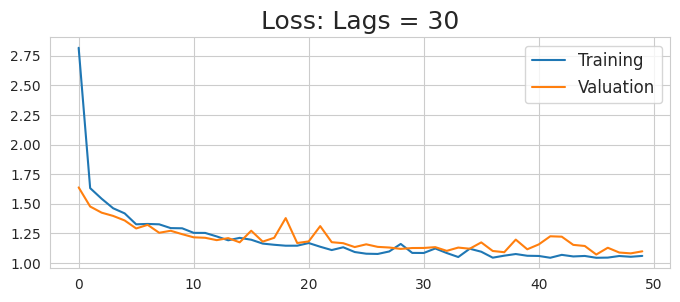

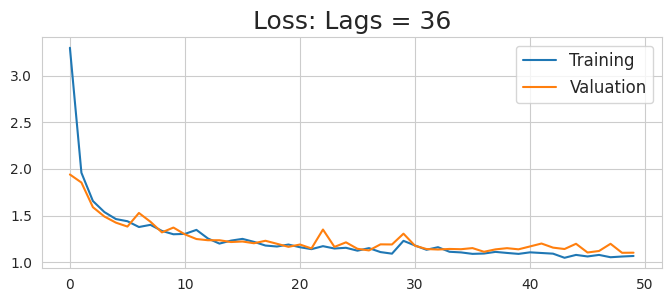

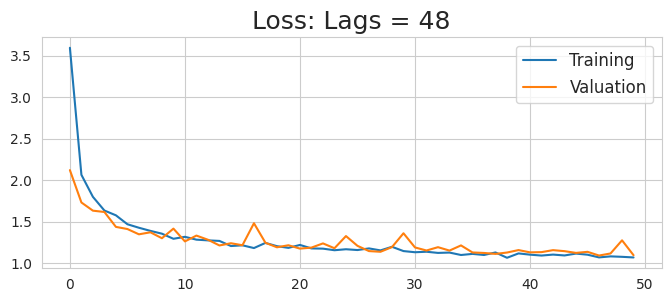

In [ ]:
history_list =[]

for p in [6, 12, 24, 30, 36, 48]:

    create_lag(p, train, valid, test, kind="LSTM")

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, p), activation='relu')))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Lags = " + str(p) + " ,MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Lags = " + str(p)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.1769545078277588 1.2988771200180054
2 1.1422473192214966 1.189491629600525
3 1.0717016458511353 1.2133965492248535
4 1.0601589679718018 1.0988503694534302
5 1.066526174545288 1.101758360862732
6 1.0679737329483032 1.0949903726577759


### Activation

24/24 [==============================] - 1s 1ms/step
Activation = softplus, MAE = 1.0527339901106108, MAPE = 0.03946054093087952


24/24 [==============================] - 0s 1ms/step
Activation = relu, MAE = 1.065150212261024, MAPE = 0.039904265046624456


24/24 [==============================] - 0s 1ms/step
Activation = linear, MAE = 1.0558207750686621, MAPE = 0.03990901501073646




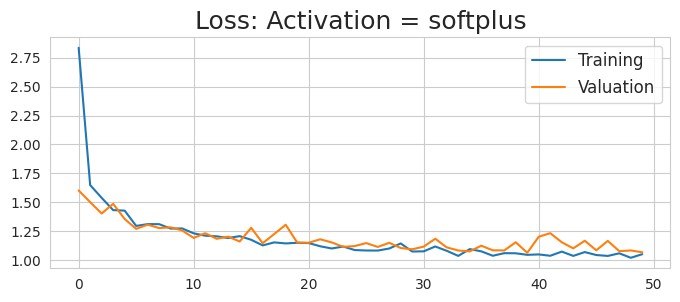

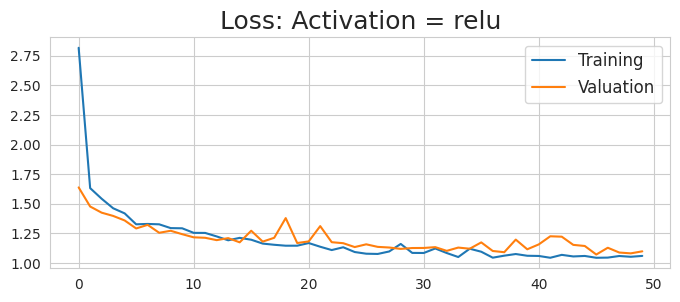

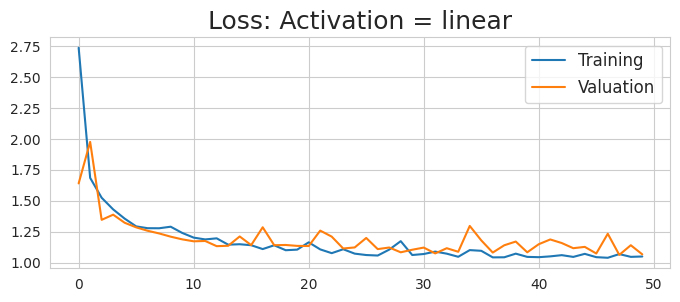

In [ ]:
history_list =[]
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
activation = ['softplus', 'relu', 'linear']

for a in activation:

    create_lag(30, train, valid, test, kind="LSTM")

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation=a)))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Activation = " + str(a) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Activation = " + str(a)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.053337574005127 1.0696879625320435
2 1.0601589679718018 1.0988503694534302
3 1.049391746520996 1.0667061805725098


### BatchNormalization

24/24 [==============================] - 0s 2ms/step
BatchNormalization, MAE = 1.649052798676191, MAPE = 0.06457423820888059




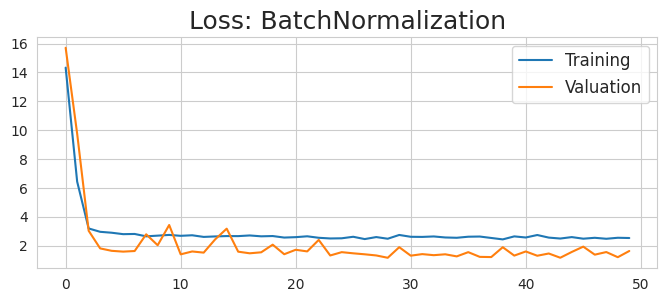

In [ ]:
history_list =[]
create_lag(30, train, valid, test, kind="LSTM")

model = Sequential()
model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation='softplus')))
model.add(BatchNormalization())
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer='adam')

history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

history_list.append(history)

y_pred = model.predict(test_ml_X_rs)
testTxt = ("BatchNormalization" + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
title = "BatchNormalization"

print(testTxt)
history_graph()
print('\n')

In [ ]:
history_df(history_list)

for i in [1]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 2.5421783924102783 1.644338607788086


### MinMax Scaler

24/24 [==============================] - 0s 2ms/step
MinMax Scaler, MAE = 1.1748923979413048, MAPE = 0.043462720525522386




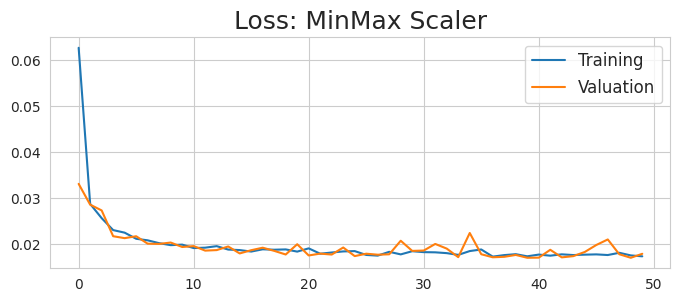

In [85]:
history_list =[]

create_lag(30, train_sc_df, valid_sc_df, test_sc_df, scale="yes", kind="LSTM")

model = Sequential()
model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation='softplus')))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer='adam')

history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

history_list.append(history)

y_pred = model.predict(test_ml_X_rs)
test_ml_Y_rv = sc.inverse_transform(test_ml_Y)
y_pred = sc.inverse_transform(y_pred)

testTxt = ("MinMax Scaler" + ", MAE = " + str(mean_absolute_error(test_ml_Y_rv, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y_rv, y_pred)))
title = "MinMax Scaler"

print(testTxt)
history_graph()
print('\n')

In [86]:
history_df(history_list)

for i in [1]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 0.01736888848245144 0.017916465178132057


### Dropout

24/24 [==============================] - 0s 2ms/step
Dropout_rate = 0.0, MAE = 1.0527339901106108, MAPE = 0.03946054093087952


24/24 [==============================] - 0s 2ms/step
Dropout_rate = 0.2, MAE = 1.6105864534114502, MAPE = 0.05828662568607868


24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.4, MAE = 1.6987169014111192, MAPE = 0.0596546065646949


24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.6, MAE = 1.815929773152334, MAPE = 0.06169761343783985


24/24 [==============================] - 0s 1ms/step
Dropout_rate = 0.8, MAE = 6.357229422960758, MAPE = 0.20950001246857328




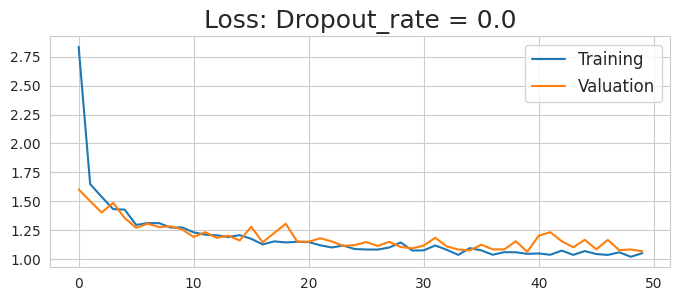

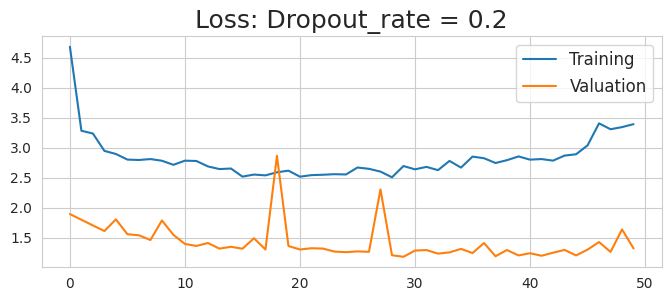

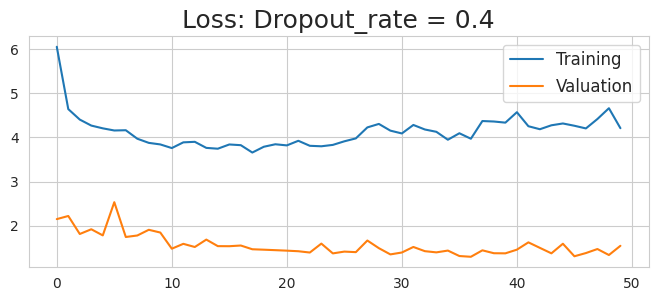

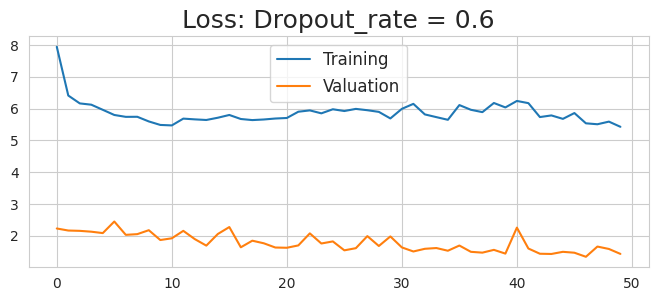

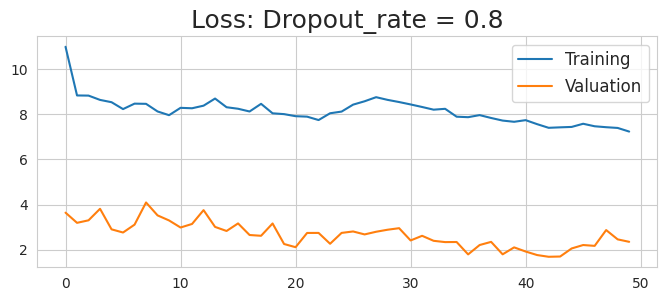

In [ ]:
history_list =[]
Dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]

for d in Dropout_rate:

    create_lag(30, train, valid, test, kind="LSTM")

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus")))
    model.add(Dropout(d))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Dropout_rate = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Dropout_rate = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3,4,5]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.053337574005127 1.0696879625320435
2 3.391228675842285 1.3220638036727905
3 4.2090349197387695 1.5474843978881836
4 5.427229404449463 1.4323835372924805
5 7.23586893081665 2.3577494621276855


### Layer Regularization

24/24 [==============================] - 0s 2ms/step
Regularization = 0.001, MAE = 1.0606931494560645, MAPE = 0.039875660700039686


24/24 [==============================] - 1s 2ms/step
Regularization = 0.01, MAE = 1.0630964021268021, MAPE = 0.040011455786802784


24/24 [==============================] - 0s 2ms/step
Regularization = 0.05, MAE = 1.1396866857092263, MAPE = 0.04321332700715402


24/24 [==============================] - 0s 2ms/step
Regularization = 0.08, MAE = 1.1073779404742818, MAPE = 0.0413744707690754


24/24 [==============================] - 0s 2ms/step
Regularization = 0.09, MAE = 1.1691207643623518, MAPE = 0.04435636718229671


24/24 [==============================] - 0s 2ms/step
Regularization = 1, MAE = 1.3604071731357674, MAPE = 0.05376023480498977




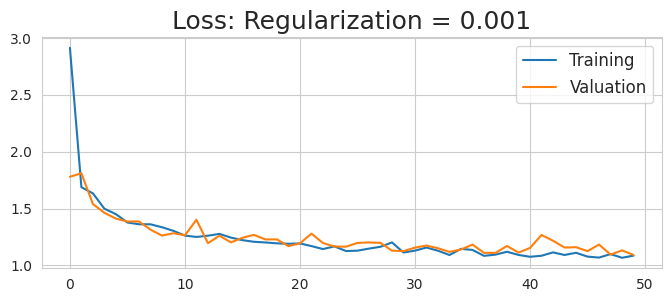

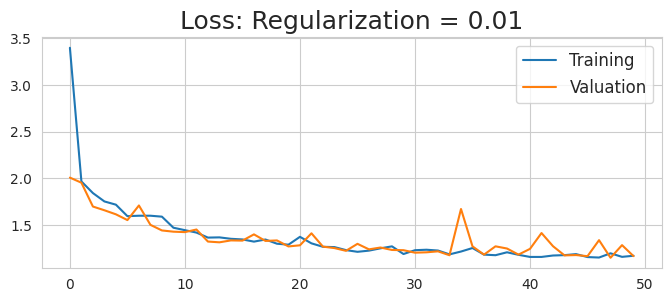

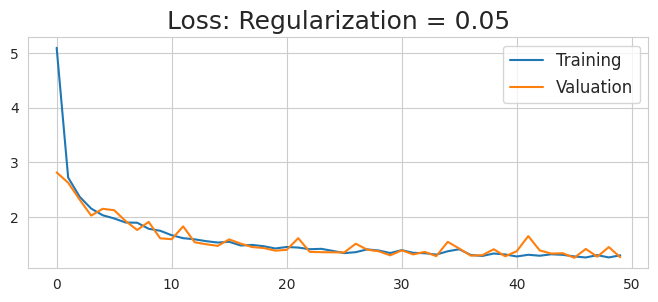

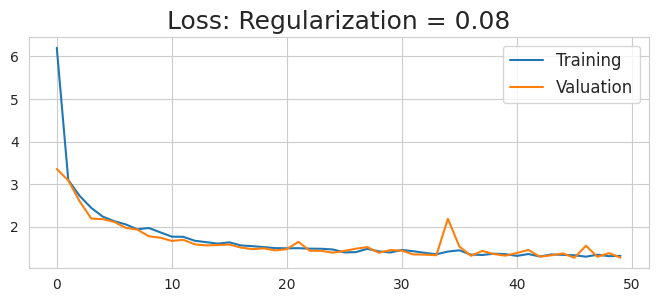

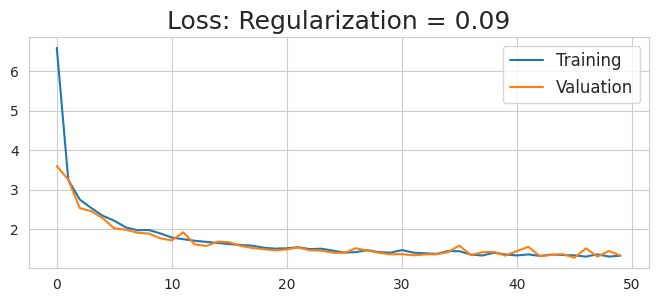

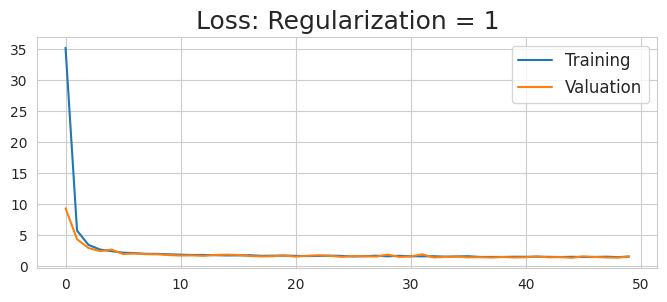

In [ ]:
history_list =[]

for r in [0.001, 0.01, 0.05, 0.08, 0.09, 1]:

    create_lag(30, train, valid, test, kind="LSTM")

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(r))))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Regularization = " + str(r) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Regularization = " + str(r)

    print(testTxt)
    history_graph()
    print('\n')

In [ ]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 1.0861175060272217 1.0920377969741821
2 1.1699057817459106 1.1657609939575195
3 1.3018460273742676 1.2663642168045044
4 1.3163471221923828 1.2750264406204224
5 1.3336145877838135 1.335536003112793
6 1.563494324684143 1.5951446294784546


### Training Optimization

24/24 [==============================] - 0s 1ms/step
Optimizer = SGD, MAE = 16.33885714892437, MAPE = 0.5484141420501767


24/24 [==============================] - 1s 1ms/step
Optimizer = RMSprop, MAE = 1.5484974317489812, MAPE = 0.058903515431876996


24/24 [==============================] - 0s 1ms/step
Optimizer = Adagrad, MAE = 1.3842492114168958, MAPE = 0.052569224559006124


24/24 [==============================] - 0s 1ms/step
Optimizer = Adadelta, MAE = 4.254205203216663, MAPE = 0.17281422432877763


24/24 [==============================] - 0s 1ms/step
Optimizer = Adam, MAE = 1.0606931494560645, MAPE = 0.039875660700039686


24/24 [==============================] - 0s 1ms/step
Optimizer = Nadam, MAE = 1.1603517324468693, MAPE = 0.04359200336098226




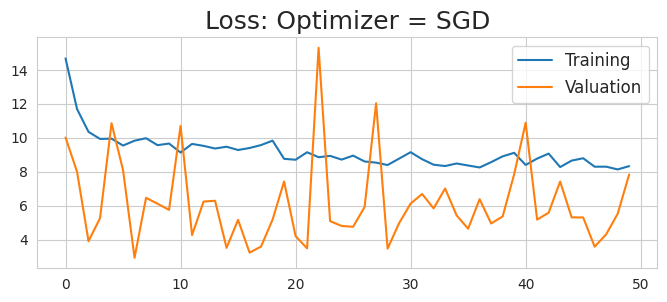

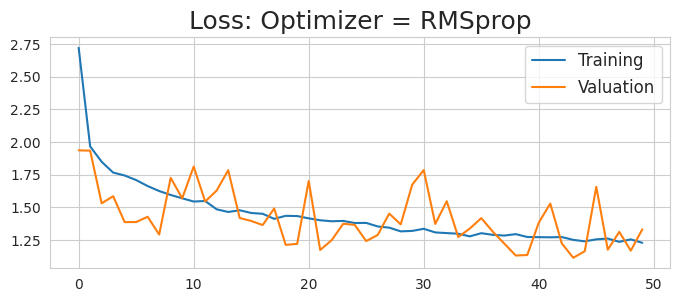

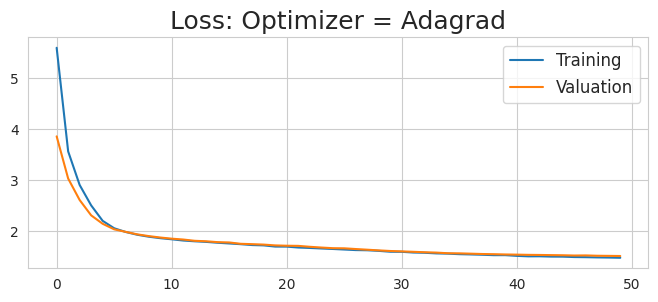

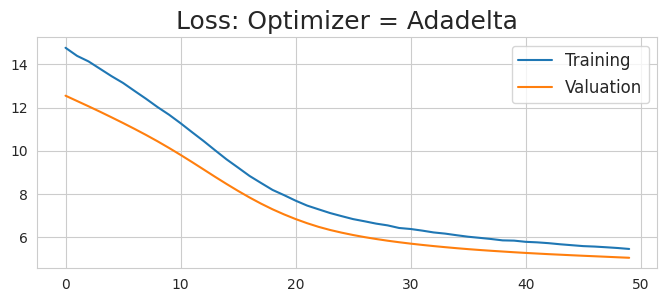

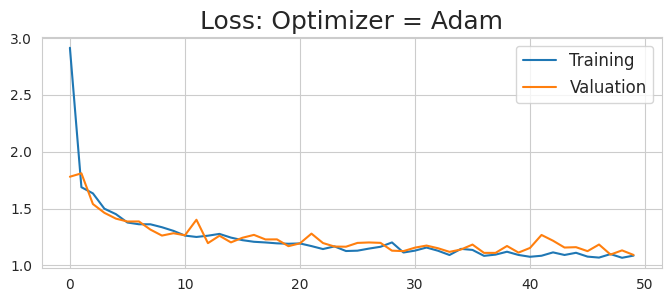

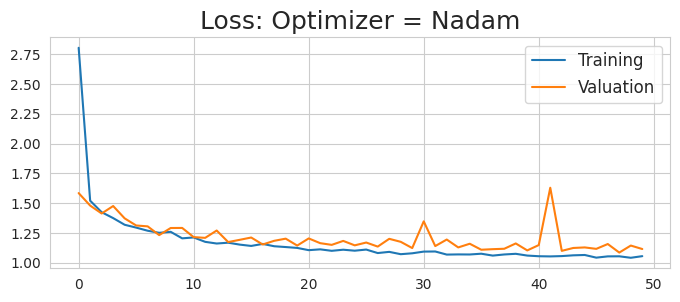

In [36]:
history_list =[]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
create_lag(30, train, valid, test, kind="LSTM")

for opt in optimizer:

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001))))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=opt)

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=50,
                batch_size=32, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Optimizer = " + str(opt) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Optimizer = " + str(opt)

    print(testTxt)
    history_graph()
    print('\n')

In [37]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][49], dfh["val_loss"].loc[dfh['Iteration'] == i][49])

1 8.338303565979004 7.847870826721191
2 1.2283316850662231 1.3316584825515747
3 1.480317234992981 1.5150264501571655
4 5.455260753631592 5.0471086502075195
5 1.0861175060272217 1.0920377969741821
6 1.0557334423065186 1.115615725517273


### Batch Size & Epochs

24/24 [==============================] - 0s 1ms/step
batch_size = 32, epochs = 30, MAE = 1.1076119313276096, MAPE = 0.04180020632185393


24/24 [==============================] - 0s 1ms/step
batch_size = 32, epochs = 60, MAE = 1.1826841543722904, MAPE = 0.04387152071228309


24/24 [==============================] - 0s 1ms/step
batch_size = 32, epochs = 100, MAE = 1.2443562712724479, MAPE = 0.04710474323976095


24/24 [==============================] - 0s 1ms/step
batch_size = 32, epochs = 120, MAE = 1.078109727445901, MAPE = 0.04072148189797654


24/24 [==============================] - 0s 1ms/step
batch_size = 64, epochs = 30, MAE = 1.1086632913052776, MAPE = 0.0416207235591894


24/24 [==============================] - 0s 1ms/step
batch_size = 64, epochs = 60, MAE = 1.2163988398990715, MAPE = 0.04480529560349255


24/24 [==============================] - 0s 1ms/step
batch_size = 64, epochs = 100, MAE = 1.0301979023695549, MAPE = 0.03903244544230747


24/24 [==========================

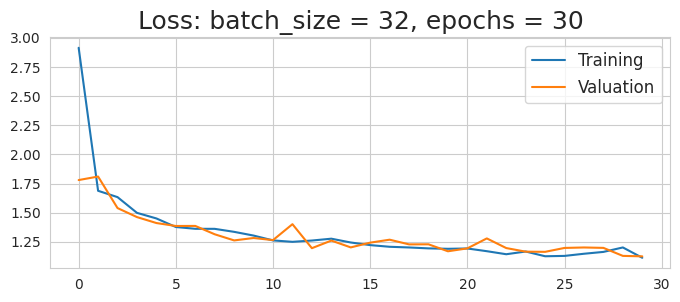

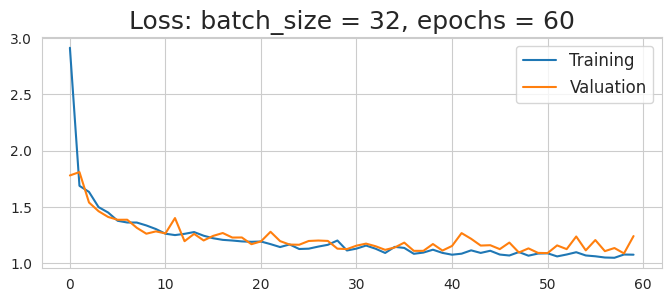

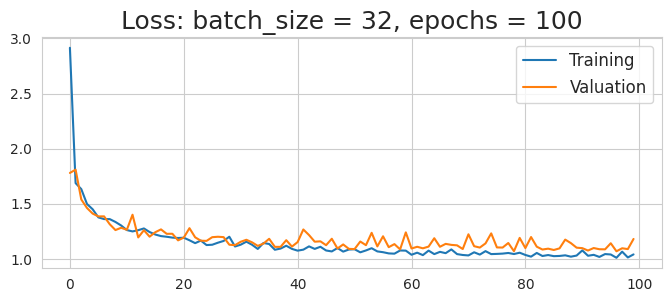

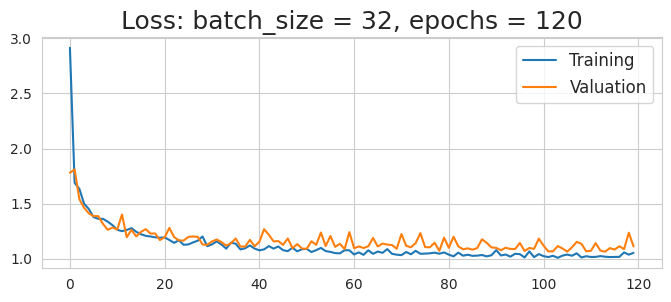

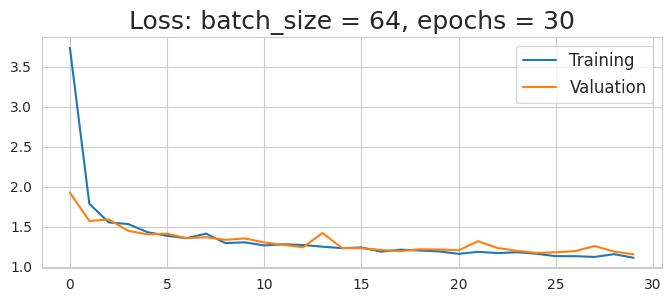

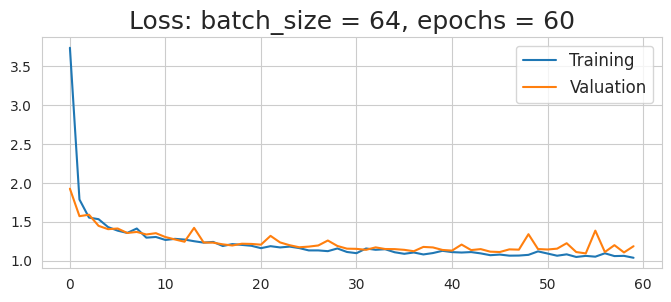

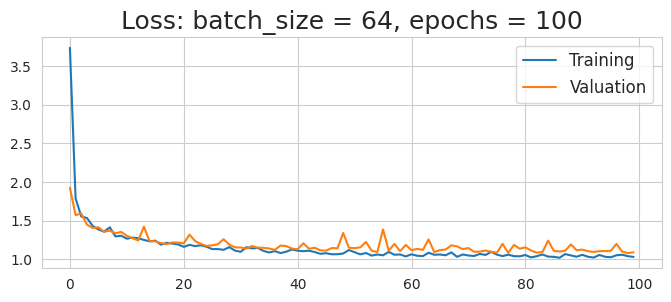

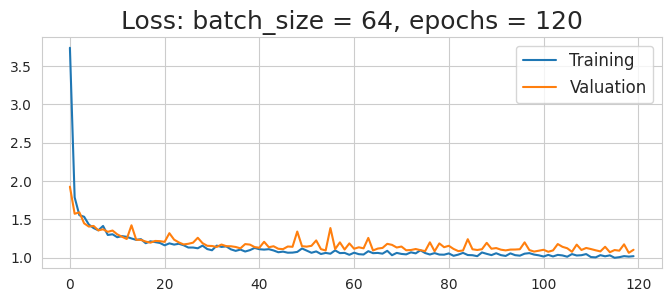

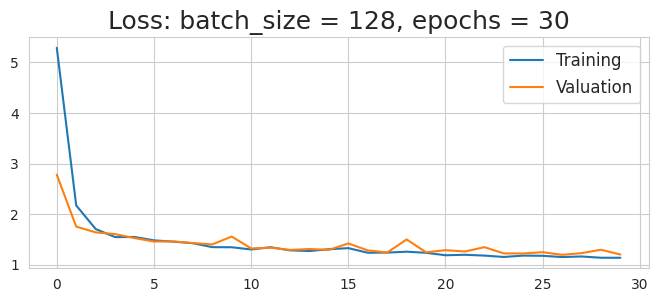

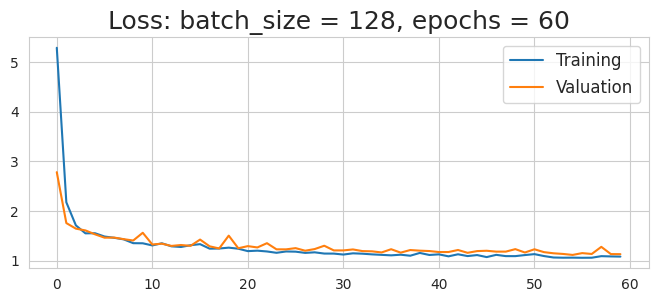

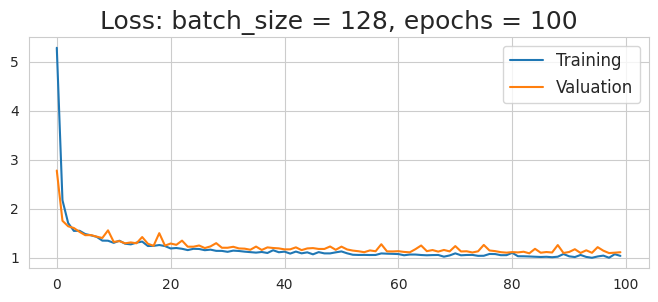

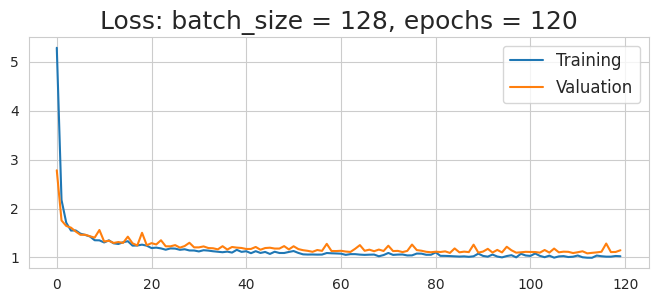

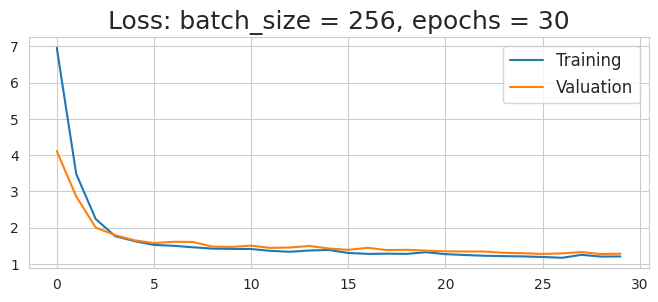

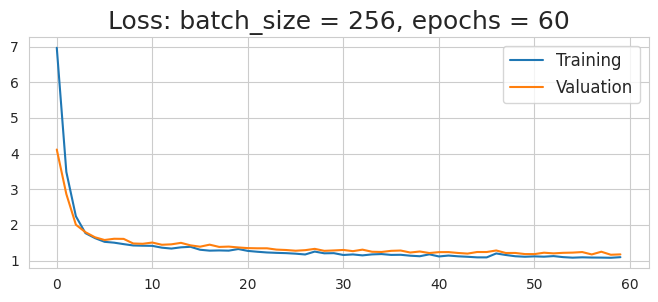

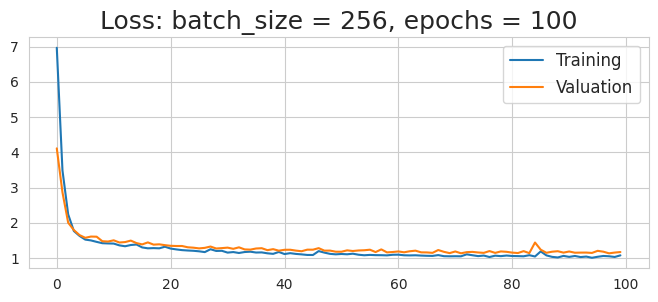

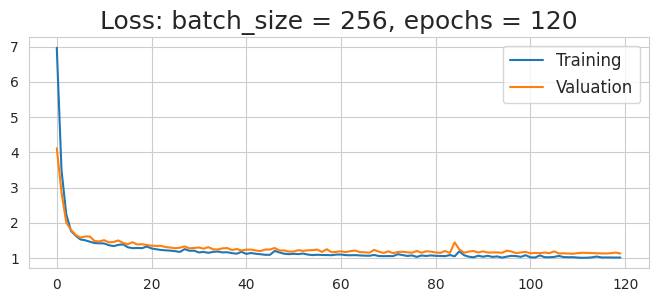

In [51]:
batch_size = [32, 64, 128, 256]
epochs = [30, 60, 100, 120]
history_list =[]

for i, j in itertools.product(batch_size, epochs):

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001))))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer='adam')

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=j,
                batch_size=i, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("batch_size = " + str(i) + ", epochs = " + str(j) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "batch_size = " + str(i) + ", epochs = " + str(j)

    print(testTxt)
    history_graph()
    print('\n')

In [53]:
history_df(history_list)

for i,j in [1,29],[2,59],[3,99],[4,119],[5,29],[6,59],[7,99],[8,119],[9,29],[10,59],[11,99],[12,119],[13,29],[14,59],[15,99],[16,119]:
    print(i, dfh["loss"].loc[dfh['Iteration'] == i][j], dfh["val_loss"].loc[dfh['Iteration'] == i][j])

1 1.1135025024414062 1.125767707824707
2 1.076059103012085 1.2415298223495483
3 1.0419405698776245 1.1818560361862183
4 1.0532842874526978 1.1115477085113525
5 1.1133921146392822 1.1559982299804688
6 1.0387808084487915 1.1874996423721313
7 1.031894564628601 1.0919934511184692
8 1.0209070444107056 1.1043517589569092
9 1.1405514478683472 1.2050013542175293
10 1.0802826881408691 1.1294852495193481
11 1.03863525390625 1.1135549545288086
12 1.023301601409912 1.145511507987976
13 1.2083135843276978 1.284435510635376
14 1.0960164070129395 1.174216628074646
15 1.0792276859283447 1.1733604669570923
16 1.012665033340454 1.126815915107727


### Learning Rate

24/24 [==============================] - 0s 1ms/step
learn_rate = 0.0005, MAE = 1.047134033477461, MAPE = 0.039690914949383635


24/24 [==============================] - 0s 1ms/step
learn_rate = 0.001, MAE = 1.0684513136472042, MAPE = 0.04016363675405043


24/24 [==============================] - 0s 1ms/step
learn_rate = 0.01, MAE = 1.0276966245561066, MAPE = 0.0388285954616611


24/24 [==============================] - 0s 1ms/step
learn_rate = 0.015, MAE = 1.064213107562475, MAPE = 0.040263528856744425




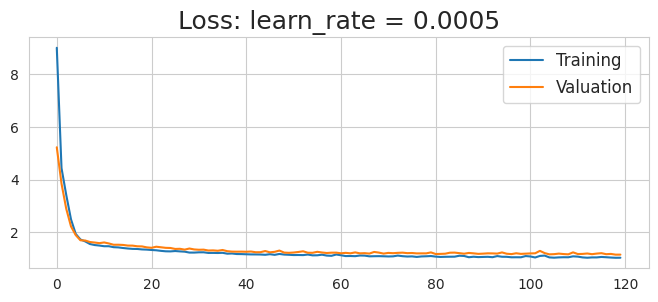

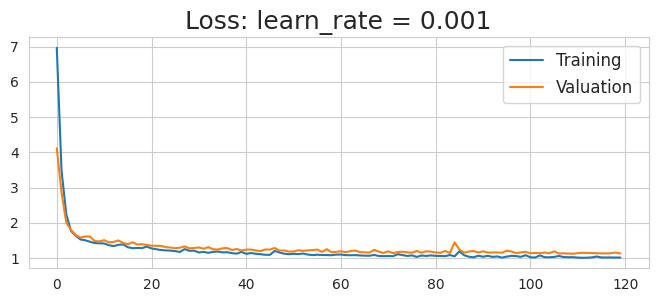

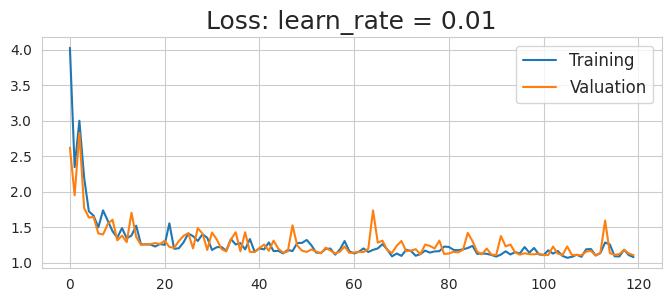

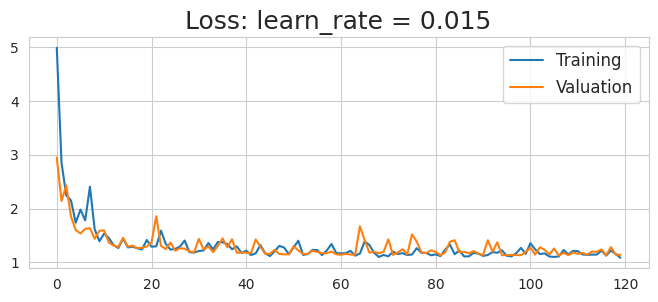

In [54]:
history_list =[]
learn_rate = [0.0005, 0.001, 0.01, 0.015]

for lr in learn_rate:

    model = Sequential()
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001))))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=120,
                batch_size=256, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("learn_rate = " + str(lr) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "learn_rate = " + str(lr)

    print(testTxt)
    history_graph()
    print('\n')

In [55]:
history_df(history_list)

for i in [1,2,3,4]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 1.0275964736938477 1.146018624305725
2 1.012665033340454 1.126815915107727
3 1.0767912864685059 1.1047470569610596
4 1.084813117980957 1.1392207145690918


### Network Topology

24/24 [==============================] - 0s 1ms/step
Units = 8, MAE = 1.0831214949654169, MAPE = 0.04118926029671567


24/24 [==============================] - 0s 1ms/step
Units = 16, MAE = 1.0521020825071006, MAPE = 0.039763329102632014


24/24 [==============================] - 0s 1ms/step
Units = 24, MAE = 1.0684513136472042, MAPE = 0.04016363675405043


24/24 [==============================] - 0s 1ms/step
Units = 30, MAE = 1.046588136698798, MAPE = 0.039478604492997615


24/24 [==============================] - 0s 1ms/step
Units = 36, MAE = 1.0458310110919218, MAPE = 0.039618432827069235


24/24 [==============================] - 0s 1ms/step
Units = 48, MAE = 1.0642703720828042, MAPE = 0.04003427245299381




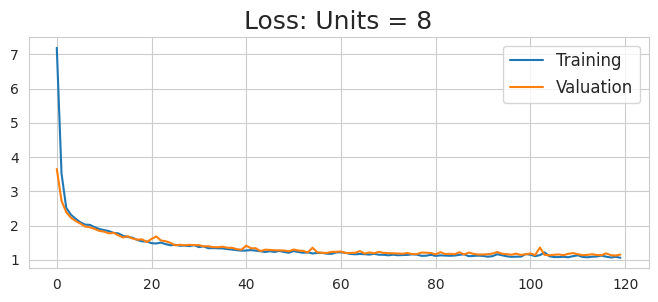

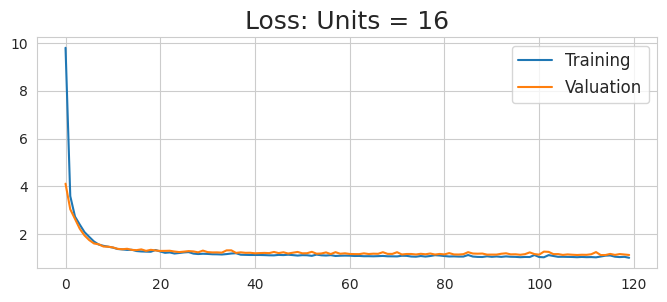

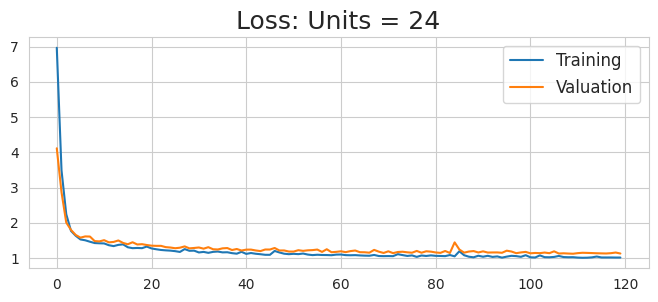

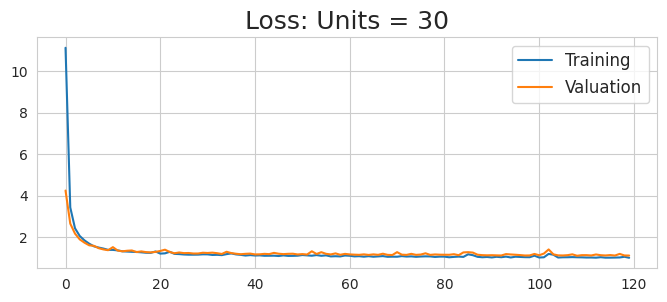

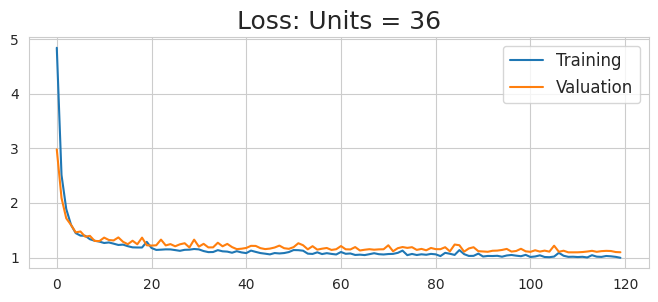

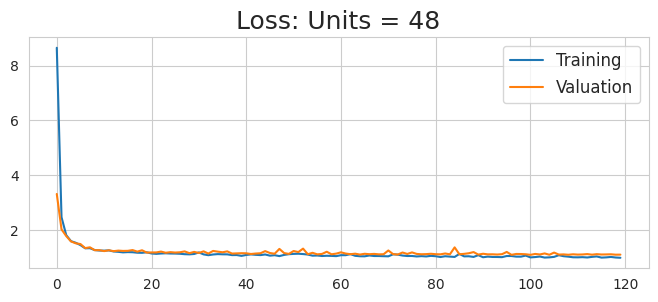

In [58]:
history_list =[]

for d in [8, 16, 24, 30, 36, 48]:

    model = Sequential()
    model.add(Bidirectional(LSTM(d, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001))))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=120,
                batch_size=256, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Units = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Units = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [60]:
history_df(history_list)

for i in [1,2,3,4,5,6]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 1.0586215257644653 1.15201997756958
2 1.0144847631454468 1.1321934461593628
3 1.012665033340454 1.126815915107727
4 1.003922939300537 1.1112570762634277
5 0.9958209991455078 1.0970041751861572
6 0.9941937327384949 1.1088674068450928


24/24 [==============================] - 0s 1ms/step
Units = 4, MAE = 1.0510727873787133, MAPE = 0.03940810043955251


24/24 [==============================] - 0s 1ms/step
Units = 8, MAE = 1.0140745549524313, MAPE = 0.03833020761858373


24/24 [==============================] - 0s 1ms/step
Units = 16, MAE = 1.035449815694455, MAPE = 0.039332090767289954


24/24 [==============================] - 0s 1ms/step
Units = 24, MAE = 1.006994743463869, MAPE = 0.03826181089523083


24/24 [==============================] - 1s 1ms/step
Units = 36, MAE = 1.0409127532375995, MAPE = 0.039528004539646264




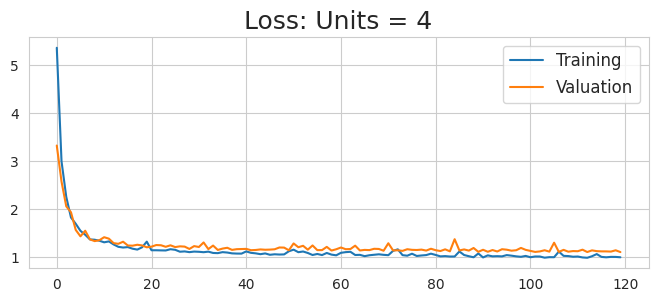

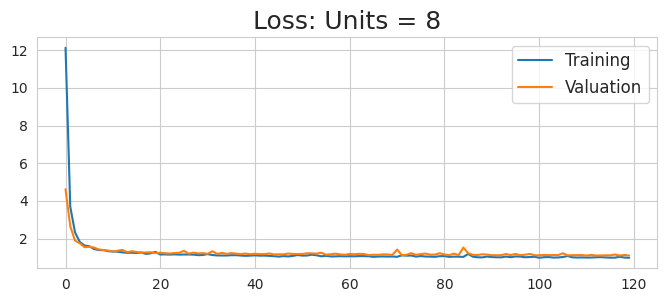

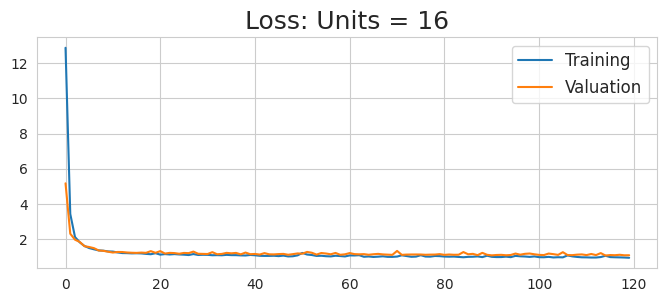

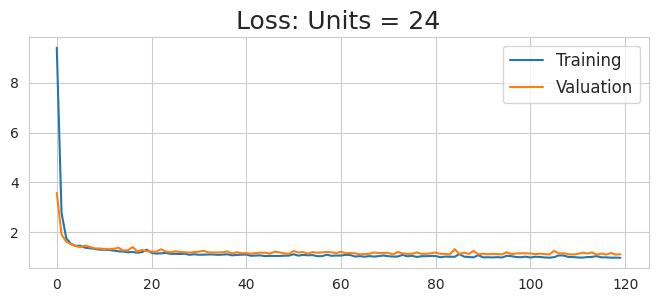

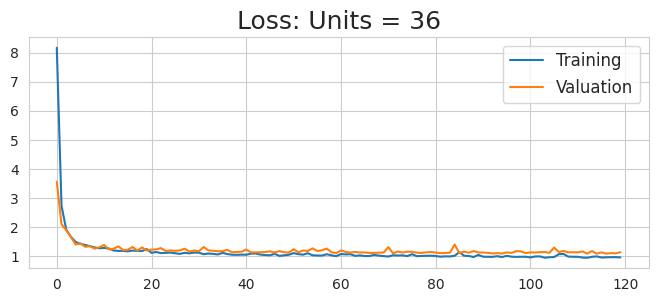

In [64]:
history_list =[]

for d in [4, 8, 16, 24, 36]:

    model = Sequential()
    model.add(Bidirectional(LSTM(36, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True)))
    model.add(Bidirectional(LSTM(d, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               activation="softplus")))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=120,
                batch_size=256, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Units = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Units = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [65]:
history_df(history_list)

for i in [1,2,3,4,5]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 1.0019114017486572 1.1098918914794922
2 0.983474850654602 1.0983449220657349
3 0.9551956057548523 1.0996874570846558
4 0.9631490111351013 1.1067206859588623
5 0.9636926651000977 1.1413908004760742


24/24 [==============================] - 1s 2ms/step
Units = 4, MAE = 1.0551527935094223, MAPE = 0.03989743783402082


24/24 [==============================] - 1s 2ms/step
Units = 8, MAE = 1.0125243525765821, MAPE = 0.037993105526735266


24/24 [==============================] - 1s 2ms/step
Units = 16, MAE = 1.0699940840086606, MAPE = 0.040723932806083524


24/24 [==============================] - 1s 2ms/step
Units = 24, MAE = 1.0285585746668588, MAPE = 0.03902610654035153


24/24 [==============================] - 1s 3ms/step
Units = 36, MAE = 1.0714099570328637, MAPE = 0.041133762259716995




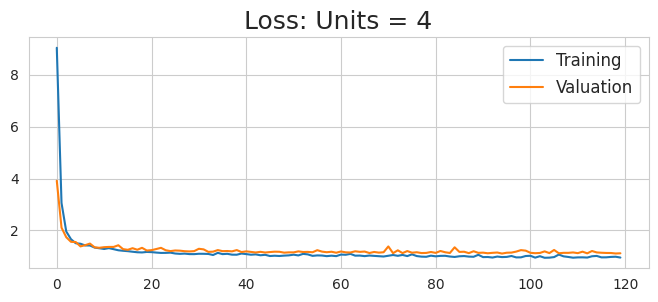

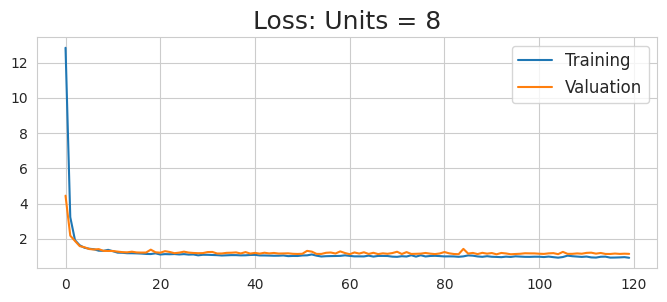

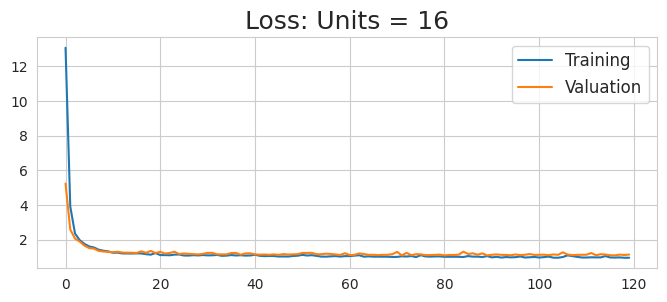

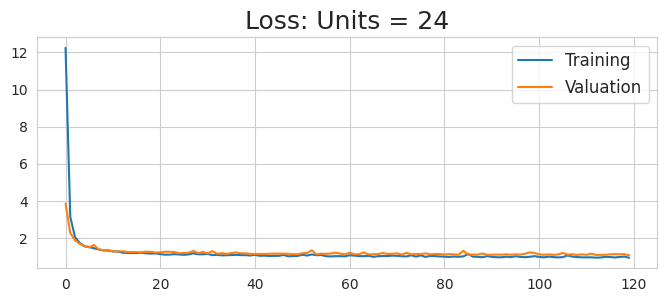

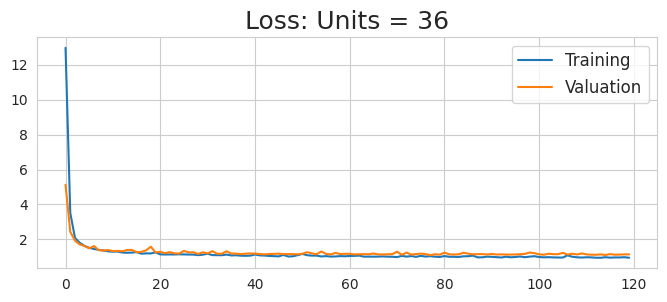

In [22]:
history_list =[]
create_lag(30, train, valid, test, kind="LSTM")

for d in [4, 8, 16, 24, 36]:

    model = Sequential()
    model.add(Bidirectional(LSTM(36, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True)))
    model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               activation="softplus", return_sequences=True)))
    model.add(Bidirectional(LSTM(d, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               activation="softplus")))
    model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
    model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    history=model.fit(train_ml_X_rs, train_ml_Y, epochs=120,
                batch_size=256, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))

    history_list.append(history)

    y_pred = model.predict(test_ml_X_rs)
    testTxt = ("Units = " + str(d) + ", MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
    title = "Units = " + str(d)

    print(testTxt)
    history_graph()
    print('\n')

In [23]:
history_df(history_list)

for i in [1,2,3,4,5]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 0.9577966928482056 1.1221201419830322
2 0.9276711344718933 1.1493215560913086
3 0.9637947678565979 1.1470385789871216
4 0.944236159324646 1.0847505331039429
5 0.9509987235069275 1.1468734741210938


### Initiazers

In [66]:
history_list =[]
create_lag(30, train, valid, test, kind="LSTM")

model = Sequential()
model.add(Bidirectional(LSTM(36, kernel_initializer=keras.initializers.glorot_normal(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True)))
model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               activation="softplus")))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history=model.fit(train_ml_X_rs, train_ml_Y, epochs=120,
                batch_size=256, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))
et = time.time()
elapsed_time = et - st

history_list.append(history)

y_pred = model.predict(test_ml_X_rs)
testTxt = ("MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
title = "LSTM"

print(testTxt)
print('\n')

24/24 [==============================] - 0s 2ms/step
MAE = 1.0177094954282022, MAPE = 0.039038055528153766




In [68]:
history_df(history_list)

for i in [1]:
  print(i, dfh["loss"].loc[dfh['Iteration'] == i][119], dfh["val_loss"].loc[dfh['Iteration'] == i][119])

1 0.9610748291015625 1.1254836320877075


### Final LSTM

In [36]:
history_list =[]
create_lag(30, train, valid, test, kind="LSTM")

st = time.time()

model = Sequential()
model.add(Bidirectional(LSTM(36, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               input_shape=(1, 30), activation="softplus", kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True)))
model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               activation="softplus")))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history=model.fit(train_ml_X_rs, train_ml_Y, epochs=120,
                batch_size=256, verbose=0, validation_data=(valid_ml_X_rs, valid_ml_Y))
et = time.time()
elapsed_time = et - st

history_list.append(history)

y_pred = model.predict(test_ml_X_rs)
testTxt = ("MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
title = "LSTM"

print(testTxt)
print(timedelta(seconds=elapsed_time))
print('\n')


24/24 [==============================] - 1s 3ms/step
MAE = 1.006994743463869, MAPE = 0.03826181089523083
0:00:51.114716




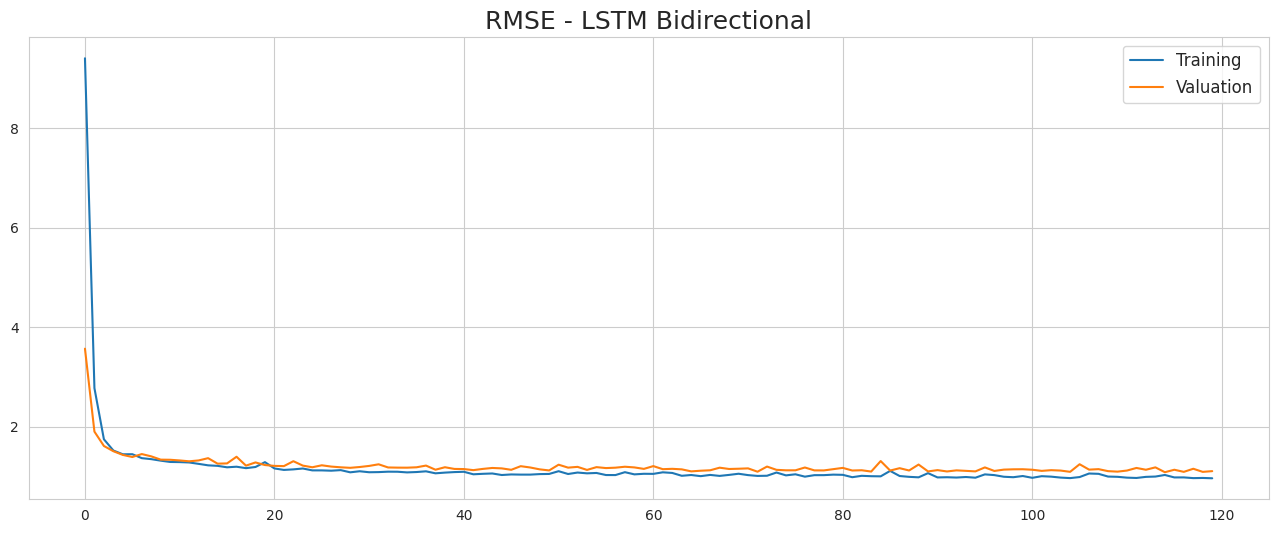

In [113]:
plt.figure(figsize=(16,6))
#plt.plot(history.history['loss'], color='cornflowerblue', label='Training')
#plt.plot(history.history['val_loss'], color='orange', label='Valuation')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Valuation')
plt.title('RMSE - LSTM Bidirectional', fontsize=18)
plt.grid(True)
plt.legend(fontsize=12)

In [38]:
df_preds = test_ml_Y.copy()
df_preds[f'preds'] = y_pred
df_preds.head()

out_0      preds
Date                                     
2021-12-01 01:00:00  23.675968  22.755793
2021-12-01 02:00:00  25.239773  24.125769
2021-12-01 03:00:00  26.844480  25.226217
2021-12-01 04:00:00  28.815815  26.784113
2021-12-01 05:00:00  30.333043  29.411711

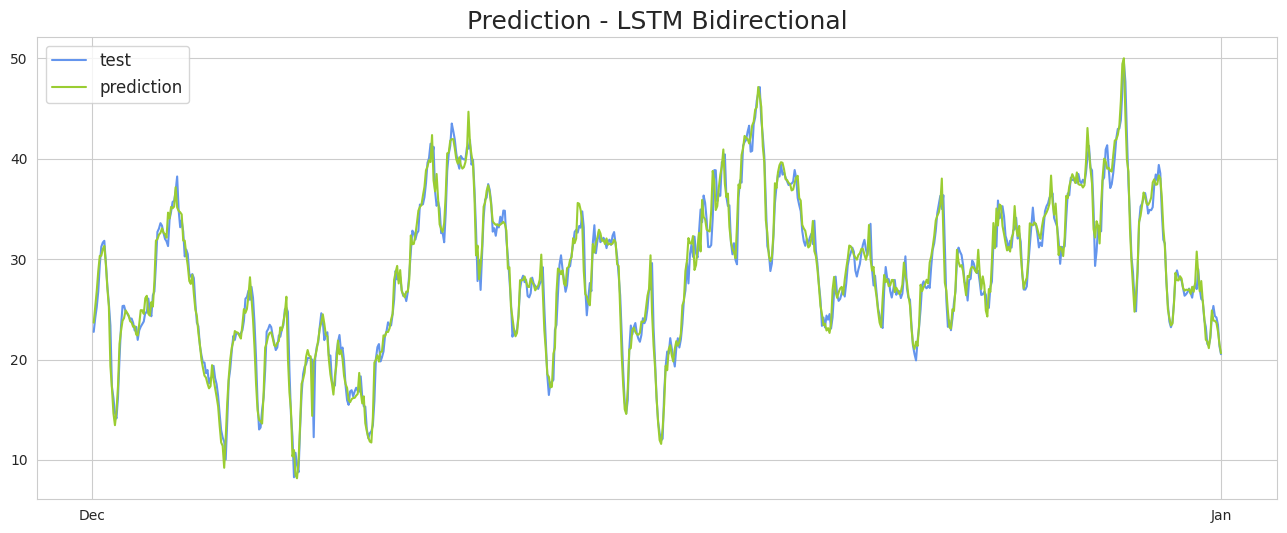

In [101]:
plt.figure(figsize=(16,6))
plt.title('Prediction - LSTM Bidirectional', fontsize=18)
plt.plot(df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

# **ES: Holt-Winters**

In [ ]:
List_Date = df.loc[(df.index.get_level_values(0))]
len(List_Date)

8760

In [ ]:
Train_Date = df.loc[(df.index.get_level_values(0) < '2021-12-01 01:00:00')]
len(Train_Date)

8016

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

List_Date = df.loc[(df.index.get_level_values(0))]
len(List_Date)

Train_Date = df.loc[(df.index.get_level_values(0) < '2021-12-01 01:00:00')]
len(Train_Date)


e = ['add']
f = ['add']

st = time.time()
for x, y in itertools.product(e,f):

    prediction=[]
    actual=[]
    d=[]
    b=0
    st = time.time()

    for i in range(len(Train_Date), len(List_Date)):

        a = df.index.get_level_values(0)[i]

        trainn_es = df.loc[(df.index.get_level_values(0) < a)]
        testt_es = df.loc[(df.index.get_level_values(0) == a)]

        model = ExponentialSmoothing(trainn_es.tail(31*24), trend=x, seasonal=y, seasonal_periods=24, freq="H")
        fit = model.fit()
        preds_optimized = fit.forecast(1)
        #print(a, preds_optimized.values, testt_es.values)

        prediction.append(float(preds_optimized.values))
        actual.append(float((testt_es['Consumption (kW)'].values)))
        d.append(a)
        b = b+1

    et = time.time()
    elapsed_time = et - st

    data = np.array([d,prediction,actual]).T
    data1 = pd.DataFrame(data, columns=['date','p','a'])
    data1.set_index('date', inplace=True)

    print('trend: ' + str(x) + ', seasonal: '+ str(y) + ', MAE: ' + str(mean_absolute_error(data1['a'], data1['p']))
      + ", MAPE = " + str(mean_absolute_percentage_error(data1['a'], data1['p'])))
    print(timedelta(seconds=elapsed_time))

trend: add, seasonal: add, MAE: 0.9109220295101392, MAPE = 0.03459721944334325
0:03:14.384755
